# 0.0 Imports

In [102]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import datetime
from tabulate import tabulate
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

## 0.1 Helper Functions

In [2]:
# Cria função para aplicar o teste V de Krammer para verificar a correlação das variáveis categóricas

def cramer_v( x, y ):
    
    # Construindo uma tabela de contingência ou matriz de confusão. 
    # Ela verifica todas as combinações das variáveis categóricas e conta o número de ocorrências. Precisamos do resultado em forma de matriz
    cm = pd.crosstab( x, y ).values
    
    # Soma de todos os valores da matriz de confusão
    n = cm.sum()

    # Número de linhas e colunas
    r, k = cm.shape
    
    # Cálculo do Qui Quadrado
    # É passado como argumento a tabela de contingência, ou confusion matrix. 
    # Estamos interessados no resultado do teste qui quadrado, que é a posição 0
    chi2 = stats.chi2_contingency( cm )[0]  
    
    # Faz a correção do viés do Crammer V, através da correção do Qui quadrado, k e r, sugerida na bibliografia
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    # Utiliza a fórmula para o cálculo do Cramer's V e faz o retorno da função
    return np.sqrt( (chi2corr/n) / ( min(kcorr-1, rcorr-1) ) )

0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_stores_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merge dos dois arquivos: sales e stores tendo como chave a coluna store
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store')

# 1.0 Descrição dos dados

In [4]:
# Faz uma cópia dos dados, para facilitar no futuro em caso de necessidade de rodar o código novamente
df1 = df_raw.copy()

In [5]:
# Exibe o nome das colunas originais para que possamos copiar
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [6]:
# Nome antigo das colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

# Cria uma função lambda para renomear as colunas antigas, com letra minuscula no inicio e underscore entre nomes
snakecase = lambda x: inflection.underscore( x )

# Aplica a função sobre a lista cols_old
cols_new = list( map ( snakecase, cols_old ) ) 

# Rename 
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions
- Qual a quantidade de linhas e colunas do dataset?

In [8]:
# Exibe número de linhas e colunas do df pelo método shape
print ( 'Number of Rows: {}'.format( df1.shape[0]) )
print ( 'Number of Columns: {}'.format( df1.shape[1]) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [9]:
# Exibe o tipo de dados do dataframe
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
# Como a data está em string, vamos mudar para date
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [11]:
# Exibe a soma de dados faltantes 
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA
- Solucionando dados NA. Vamos analisar cada uma das colunas com NAs entendendo o significado do dado e sua 
importância no problema de negócio. 

In [12]:
# Verifica valor máximo da distância do competidor mais próximo antes do tratamento
df1['competition_distance'].max()

75860.0

Coluna Competition_distance: é a distância do competidor mais próximo. 

- Solução: se essa coluna está vazia, é porque não tenho um competidor mais próximo ou esse competidor está tão distante que não é relevante. Podemos então colocar valores acima da máxima distância observada para um próximo competidor. 

- Vamos utilizar o método math.isnan, presente na biblioteca math (temos que colocar um import math no código). Esse método informa se a coluna tem dados faltantes.

- Vamos verificar o valor máximo até o competidor mais próximo usando o método df1[‘competition_distance’].max()

- O valor retornado foi de 75860. Então, colocaremos um valor muito mais alto na coluna quando estiver um dado faltante (200000). Se não tivermos um valor faltante na coluna, retornaremos o valor que já existia. 

In [13]:
# Função para atribuir ao campo competition_distance que estiver com dado faltante um valor acima da máxima distância do competidor
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )  

In [14]:
# Verifica os dados faltantes após aplicação da função
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Coluna Competition_open_since_month: mês que o competidor mais próximo foi aberto

- Há duas razões para esse campo estar vazio: não há um competidor mais próximo; a loja tem um competidor mas não sabemos quando ela abriu (ela abriu antes da nossa loja ou alguém se esqueceu de anotar).

- Solução: se esse campo for vazio, vou copiar o mês da venda naquela determinada linha e incluir no campo “competition_open_since_month.

- Parece ilógica essa ideia, mas a questão é que na parte de machine learning, esse tempo de existência do competidor será importante. Como não sabemos exatamente quando ele se instalou, temos que a existência de dados em competition_distance é uma garantia de que há um competidor. Logo, a data da venda é uma garantia mínima em termos de data para saber que havia um competidor.

- Utilizaremos novamente funções lambda. A lógica é: se o campo naquela linha tiver dado faltante, ele pegará o mês da data de venda e substituirá esse valor faltante. Se não for faltante, continua com o valor de ‘competition_open_since_month’. Isso será aplicado para todas as colunas‘competition_open_since_month’ em todas as linhas do df1. Para isso, o apply será para todo o df1. Como vou alterar apenas essa coluna específica, informo no início da linha de código. Ao final, especifico axis=1 pois trabalharei com mais de uma coluna

In [15]:
# Tratando os dados faltantes em competition_open_since_month 
df1['competition_open_since_month'] = df1.apply ( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

- Coluna competition_open_since_year: mesma ideia da coluna anterior, porém, aplicado ao ano

In [16]:
# Tratando competition_open_since_year
df1['competition_open_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )


Coluna promo2_since_week

- Esse campo descreve o ano e a semana do calendário que a loja começou a participar da promo2. A promo2 é a continuação de uma promoção feita em algumas lojas. Algumas lojas entram nessa segunda promoção, outras não (ficam apenas na primeira promoção). 

- Se os dados forem NA, a loja decidiu não participar da continuação da promoção ou não temos essa semana que ela iniciou a participação informada.
 
- Solução: vamos fazer como na ‘competition_open_since_month’. Vamos substituir esse dado faltante para o valor da semana da data da venda. O código é o mesmo. Vamos apenas substituir mês por semana.

In [17]:
# Tratando os dados faltantes em promo2_since_week
df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )         

In [18]:
# Tratando os dados faltantes em promo2_since_year
df1['promo2_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )    

Coluna Promo_interval: mostra os meses que se iniciaram promoções durante o ano. Por exemplo, se uma promoção se iniciou em setembro, novembro e dezembro, nessa coluna esses meses estará listados de forma abreviada.

- Se estiver com dado faltante, significa que não houve nenhum mês com promoção ou então se esqueceu de informar. Vamos fazer o seguinte nesse caso: o mês informado na data de venda será convertido de número para abreviação do mês referente. 

- Vamos criar colunas auxiliares (dicionarios com chave e valor) que substituirão 1 por jan; 2 por fev; 3 por mar, e assim por diante. Isso será importante para pegarmos o mês da data e informar na coluna. 

- Vamos colocar zero onde tiver dados faltantes em promo_interval

- Criaremos uma coluna que recebe o nome do mês da data de venda, utilizando esse dicionário com chave e valor.

- Agora, teremos que conferir se o mês da data está no intervalo da coluna promo_interval que não tem dado faltante.

In [19]:
# Tratando os dados faltantes em promo_interval

# Criando um dicionário para fazermos o mapeamento do nome dos meses 
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

# Colocar zeros onde tiver dado faltante
df1['promo_interval'].fillna( 0, inplace=True )

# Cria nova coluna que recebe o nome do mês da data de venda, com base no mapeamento
df1['month_map'] = df1['date'].dt.month.map( month_map )


In [20]:
# Conferindo o resultado do código
df1.sample(5).T

,634973,577147,256170,107742,363272
store,209,363,196,703,801
day_of_week,1,4,3,7,1
date,2013-12-09 00:00:00,2014-01-30 00:00:00,2014-12-10 00:00:00,2015-04-26 00:00:00,2014-08-18 00:00:00
sales,6722,5573,4373,0,8326
customers,678,774,598,0,744
open,1,1,1,0,1
promo,0,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,1
store_type,a,a,c,a,d


- Temos um campo para o nome do mês baseado na data. Precisamos verificar se esse mês está dentro do intervalo informado em promo interval. 
Se sim, então na data dessa venda estava dentro de uma promoção. 
- Vamos criar um campo para informar se havia promoção ou não na data da venda. 0 para não; 1 para sim

In [21]:
# Cria uma coluna para verificar se no mês da venda havia promoção
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [22]:
# Conferindo o resultado do código
df1.sample(5).T

,314316,392115,376264,396981,528351
store,394,627,685,860,627
day_of_week,4,5,1,7,6
date,2014-10-09 00:00:00,2014-07-18 00:00:00,2014-08-04 00:00:00,2014-07-13 00:00:00,2014-03-15 00:00:00
sales,7884,6297,10038,0,7661
customers,637,617,825,0,788
open,1,1,1,0,1
promo,1,1,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,d,c,a,c,c


In [23]:
# Confere os dados faltantes no em todo o df para verificar o resultado das operações
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [24]:
# Confere o tipo de dados
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [25]:
# Transformação de dados nas colunas que alteramos
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

# Confere as alterações
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Estatistical

- Criaremos um dataset para os dados numéricos e um dataset para os dados categóricos para possibilitar a análise estatística

In [26]:
num_attributes = df1.select_dtypes( include=['int64', 'int32', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'int32', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [27]:
# Medidas de tendência central: média, mediana
tc1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
tc2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Medidas de dispersão: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T

# Concatenar
metrics = pd.concat( [d2, d3, d4, tc1, tc2, d1, d5, d6] ).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\giova\AppData\Local\Temp\ipykernel_85784\3621938716.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['sales'] )


<Axes: xlabel='sales', ylabel='Density'>

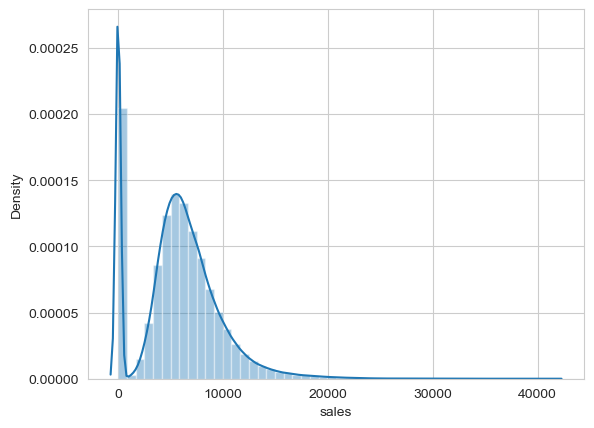

In [28]:
# Plotar gráfico de distribuição de sales
sns.set_style("whitegrid")
sns.distplot( df1['sales'] )

C:\Users\giova\AppData\Local\Temp\ipykernel_85784\2493394500.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['competition_distance'] )


<Axes: xlabel='competition_distance', ylabel='Density'>

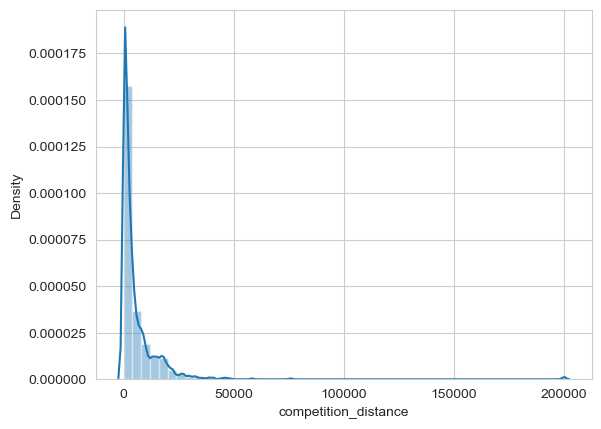

In [29]:
# Plotar distribuição da distância dos competidores
sns.distplot( df1['competition_distance'] ) 

- Observa-se uma grande concentração dos competidores próximos à loja. 

### 1.7.2. Categorical Attributes

In [30]:
# Analise dos dados categóricos
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

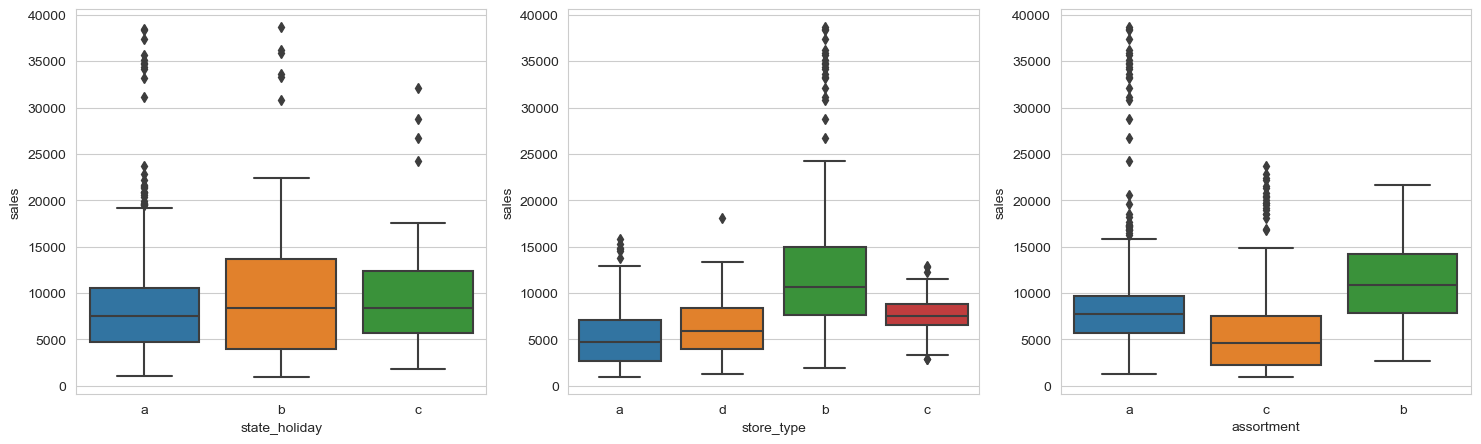

In [31]:
# Filtra os dados a serem exibidos no boxplot
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]


plt.figure(figsize=(18,5))

# Constroi box plot dos state_holydar x sales
plt.subplot(1, 3, 1)

sns.boxplot( x = 'state_holiday', y='sales', data=aux1)

# Constroi box plot dos store_type x sales
plt.subplot(1, 3, 2)

sns.boxplot( x = 'store_type', y='sales', data=aux1)


# Constroi box plot dos assortment x sales
plt.subplot(1, 3, 3)

sns.boxplot( x = 'assortment', y='sales', data=aux1)

Análise: 
Vendas em relaçaõ ao feriado estadual
- Mediana no feriado B é maior que a do A, e muito próxima do feriado C. 
- Há um equilíbrio de A e B das vendas entre o quartil 25 e 50. 
- Em A e B, há equilíbrio do número de vendas entre os quartis 25 e 50, e 50 e 75
- Em C, a maior parte das vendas se concentram entre o quartil 50 e 75 

Análise:
Vendas em relação ao tipo de loja
- O tipo de loja B possui número de vendas com maior mediana, além de maior concentração de outliers em valores superiores. 
- Essa loja também possui maior concentração de vendas acima do quartil 50. 
- Isso mostra que, de fato, é uma loja com média de vendas bem superior às demais. 
- Em segundo lugar de vendas, temos C, onde há maior concentração das vendas em torno da mediana. 

Análise: Mix de produtos
- O mix de produtos B tem valor de vendas com mediana superior aos demais. 
- Nos três mix, há concentração em torno da mediana, com C tendo menor mediana e A com maior número de outliers em valores superiores. 

# 2.0 - Feature Enginnering

In [32]:
# Cria uma cópia do df1. Em caso de problemas, podemos rodar o código daqui. 
df2 = df1.copy()

### 2.1 - Mapa Mental de Hipóteses

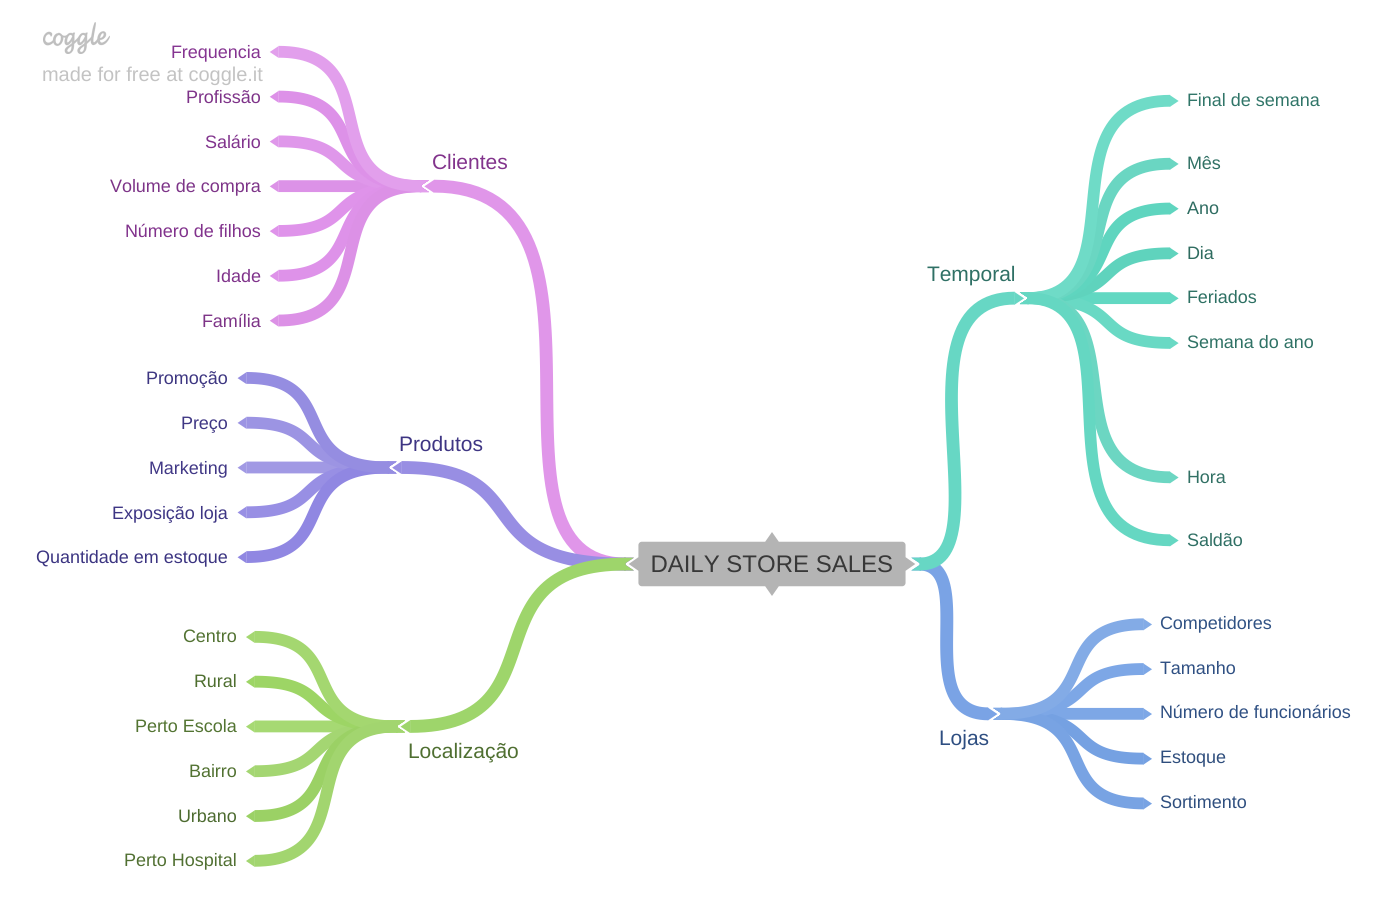

In [33]:
# Exibir mapa mental 
Image( 'img/mind_map_hypotesis.png' )

## 2.2 - Criação das Hipóteses

### 2.2.1 - Hipótese Lojas

- 1. Lojas com maior quadro de funcionários deveriam vender mais. 
- 2. Lojas com maior capacidade de estoque deveriam vender mais. 
- 3. Lojas com maior porte deveriam vender mais. 
- 4. Lojas com maior sortimento deveriam vender mais.
- 5. Lojas com competidores mais próximos deveriam vender menos. 
- 6. Lojas com competidores a mais tempo deveriam vender mais.  

### 2.2.2 - Hipótese Produto

- 1. Lojas com maior investimento em Marketing deveriam vender mais. 
- 2. Lojas com maior exposição dos produtos nas vitrines deveriam vender mais. 
- 3. Lojas com produtos com preços menores deveriam vender mais. 
- 4. Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais. 
- 5. Lojas com promoções ativas por mais tempo deveriam vender mais. 
- 6. Lojas com mais dias de promoção deveriam vender mais. 
- 7. Lojas com mais promoções consecultivas deveriam vender mais.   

### 2.2.3 - Hipótese Temporal (Sazonalidade)

- 1. Lojas abertas durante o feriado de Natal deveriam vender mais. 
- 2. Lojas deveriam vender mais ao longo dos anos. 
- 3. Lojas deveriam vender mais no segundo semestre do ano.
- 4. Lojas deveriam vender mais após o dia 10 de cada mês. 
- 5. Lojas deveriam vender menos aos finais de semana. 
- 6. Lojas deveriam vender menos durante os feriados escolares.   

## 2.3. Lista Final de Hipóteses (hipóteses que temos dados para comprovar)

- 1. Lojas com maior sortimento deveriam vender mais.
- 2. Lojas com competidores mais próximos deveriam vender menos. 
- 3. Lojas com competidores a mais tempo deveriam vender mais.  
- 4. Lojas com promoções ativas por mais tempo deveriam vender mais. 
- 5. Lojas com mais dias de promoção deveriam vender mais. 
- 6. Lojas com mais promoções consecultivas deveriam vender mais.  
- 7. Lojas abertas durante o feriado de Natal deveriam vender mais. 
- 8. Lojas deveriam vender mais ao longo dos anos. 
- 9. Lojas deveriam vender mais no segundo semestre do ano.
- 10. Lojas deveriam vender mais após o dia 10 de cada mês. 
- 11. Lojas deveriam vender menos aos finais de semana. 
- 12. Lojas deveriam vender menos durante os feriados escolares.    

## 2.4. Feature Engineering

Variáveis a serem derivadas da variável data

In [34]:
#####  year
df2['year'] = df2['date'].dt.year

##### month
df2['month'] = df2['date'].dt.month

##### day
df2['day'] = df2['date'].dt.day

##### week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

##### year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


####### competition since

# Percorre todas as linhas do df2 e monta uma data a partir de 2 colunas para fazer a diferença em meses
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )

# Tempo de competição em meses, dado pela diferença da data de inicio da loja e da abertura do competidor
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days).astype( int )


####### promo since

# Monta a data de início da promoção com ano e semana do ano (será preciso passar para string para fazer a junção)
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

# Faz a subtração da data acima convertida, menos 7 dias. Não é necessario usar axis=1 porque vamos aplicar só sobre a coluna promo_since
df2['promo_since'] = df2['promo_since'].apply( lambda x: ( datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) ) ) 

# Cria uma coluna com o tempo da promoção em semanas, dada pela subtração da data pela data de inicio da promocao
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )



##### assortment
# obs: de acordo com a base de dados Rossman: a = basic; b = extra; c = extended

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' ) 

##### state holiday
# obs: de acordo com a base de dados: a = public holiday, b = Easter holiday, c = Christmas, 0 = None

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 


In [35]:
# Exibe o df2 com as alterações até o momento
df2.sample(10).T

,765899,148633,183485,876287,354309,942961,312831,280184,107021,760359
store,680,339,626,683,147,457,860,953,1097,715
day_of_week,3,5,2,2,3,5,6,6,1,1
date,2013-08-14 00:00:00,2015-03-20 00:00:00,2015-02-17 00:00:00,2013-05-07 00:00:00,2014-08-27 00:00:00,2013-03-08 00:00:00,2014-10-11 00:00:00,2014-11-15 00:00:00,2015-04-27 00:00:00,2013-08-19 00:00:00
sales,4898,5409,10144,9755,5778,4286,5894,2511,11551,4501
customers,753,709,839,977,759,410,812,244,2753,556
open,1,1,1,1,1,1,1,1,1,1
promo,1,1,1,0,0,1,0,0,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,1,0,0,0,0,0,0,1
store_type,c,a,c,a,d,d,c,a,b,a


# 3.0. Filtragem de Variáveis

In [36]:
# Cria uma cópia do df2
df3 = df2.copy()

In [37]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.1. Filtragem das linhas

In [38]:
# A variável open só é interessante se a loja estiver aberta, ou seja, 1
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]


### 3.2. Seleção das colunas

In [39]:
# Variáveis que sairão do modelo. Open, por exemplo, não tem variabilidade. É tudo 1, não faz sentido manter
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3.drop( cols_drop, axis=1, inplace=True )


In [40]:
# Exibe as colunas existentes
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Análise Exploratória dos Dados

In [41]:
# Faz uma cópia do dataframe
df4 = df3.copy()

## 4.1. Análise Univariada

4.1.1. Response Variable

C:\Users\giova\AppData\Local\Temp\ipykernel_85784\1780214632.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['sales'], kde=False )


<Axes: xlabel='sales'>

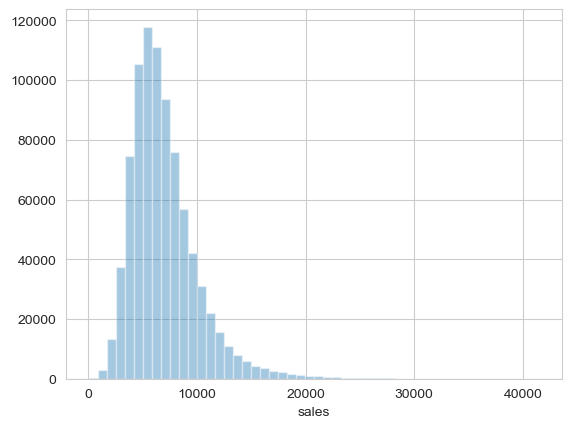

In [42]:
# Plota gráfico de distribuição da variável resposta: Sales
sns.set_style("whitegrid")
sns.distplot( df4['sales'], kde=False )

- É bom lembrar que o ideal para a maior parte dos algoritmos é que se siga as premissas estatísticas de independência das variáveis e normalidade dos dados. 
- Quanto melhor a variável estiver em relação a essas premissas, melhor vai performar o algoritmo. 
- A variável sales não tem uma distribuição exatamente como uma distribuição normal. Observa-se que há um leve deslocamento para a esquerda. 
- Há técnicas de transformações para transformar a distribuição de uma variável resposta para algo mais próximo de uma distribuição normal. Exemplo: BoxCox, Log, etc. 

4.1.2. Numerical Variable

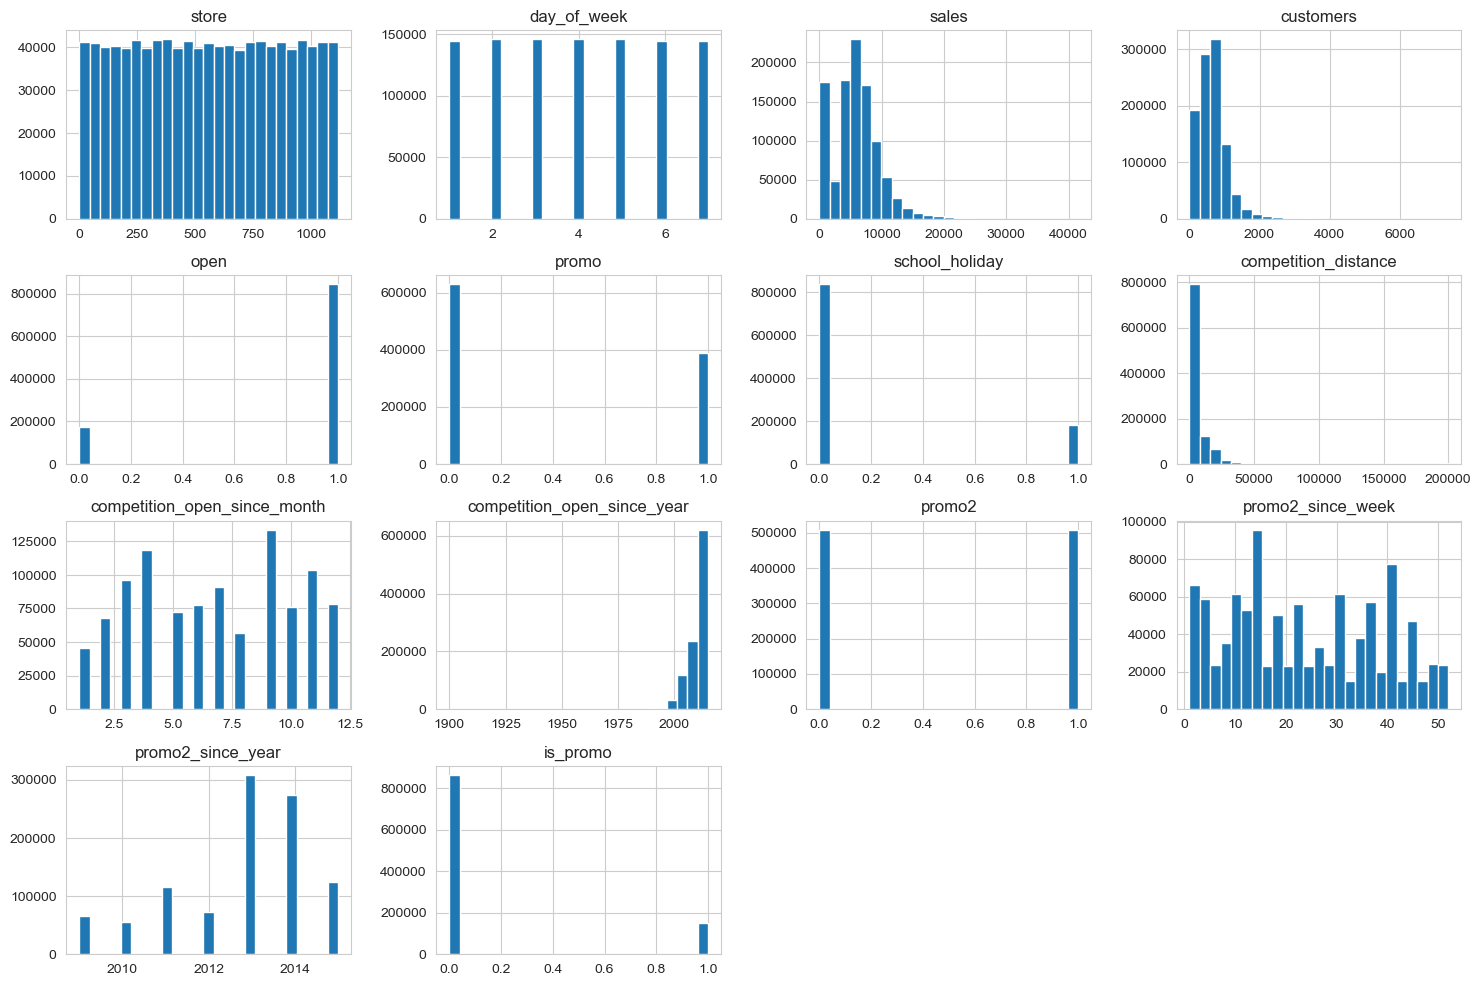

In [43]:
# Plota histograma de todas as variáveis numéricas do df
num_attributes.hist( figsize= [18, 12], bins=25 );

4.1.3. Categorical Variable

In [44]:
# Exibe as variáveis categóricas do df
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [45]:
#### state holiday
# Retira (dropa) da variável state_holiday as duplicações. 
# Isso fará com que fiquemos com os tipos de feriado originais e possamos contar as linhas para cada feriado a fim de verificar qual feriado impacta mais

df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

- Observamos que, dentre os feriados, o Natal é o de maior impacto nas vendas

<Axes: xlabel='state_holiday', ylabel='count'>

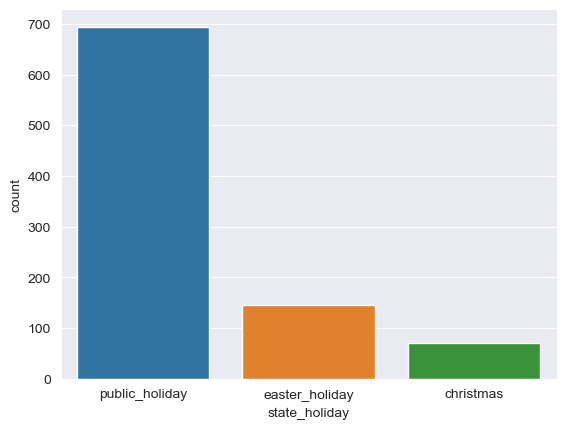

In [46]:
# Plota gráfico de contagem das linhas em state_holiday
a = df4[df4['state_holiday'] != 'regular_day']

sns.set_style('darkgrid')
sns.countplot(x=a['state_holiday'])

In [47]:
##### Store type
# Retira (dropa) da variável store type as duplicações. 

df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [48]:
##### assortment
# Retira (dropa) da variável assortment as duplicatas
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\giova\AppData\Local\Temp\ipykernel_85784\2150675076.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot( 3, 2, 1)


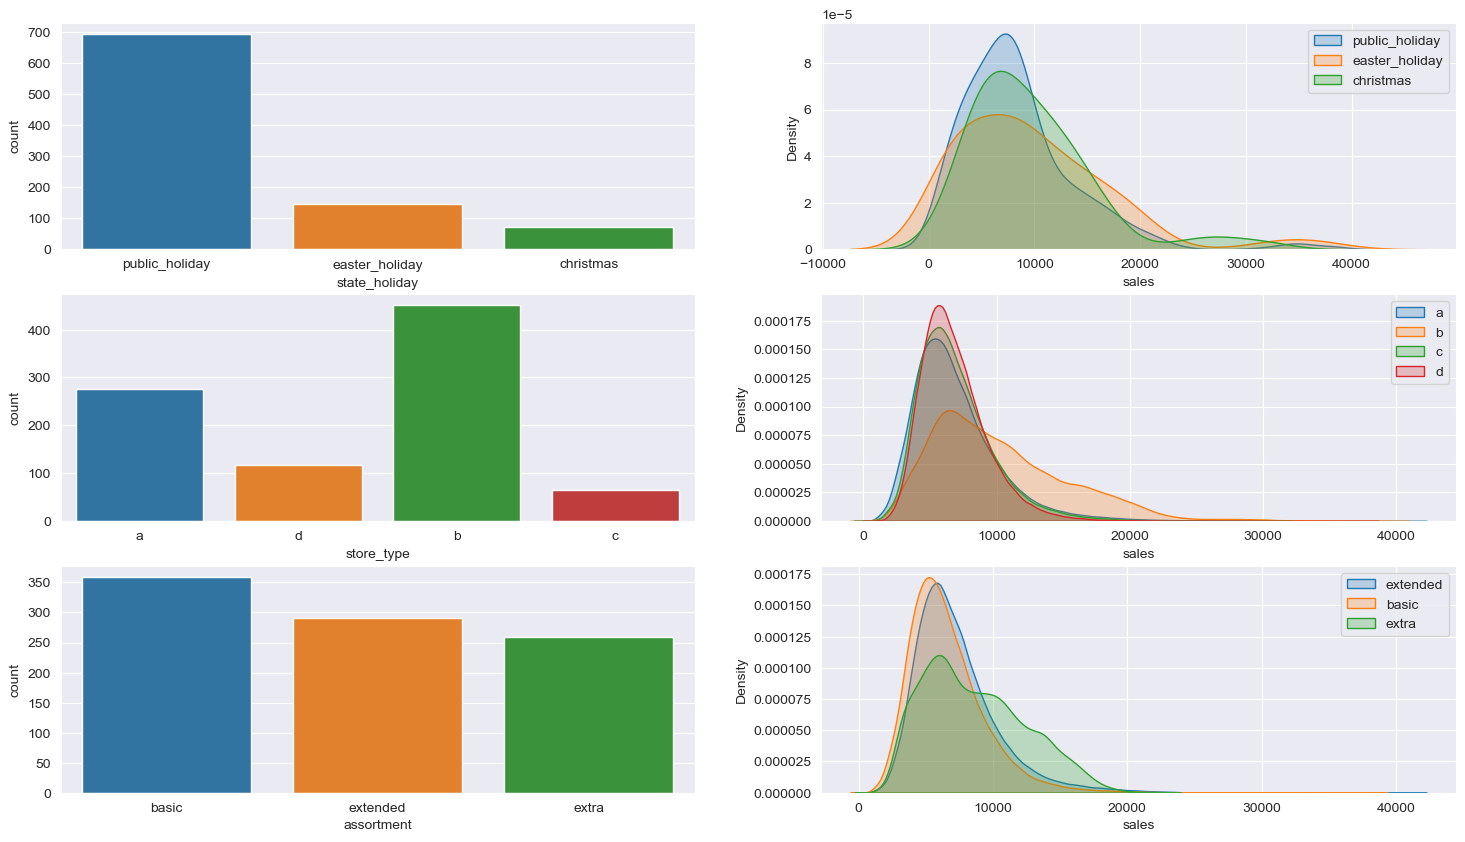

In [49]:
# Plota gráfico de contagem dos vendas por feriados, incluindo kde plot de cada feriado
sns.set_style('darkgrid')
#Seta tamanho do gráfico
fig, ax = plt.subplots(figsize=(18,10))

###### Gráficos para state_holiday

plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])

plt.subplot( 3, 2, 2 )
sns.kdeplot( x=df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot( x=df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot( x=df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

# Inclui legenda
plt.legend(labels=[ 'public_holiday', 'easter_holiday', 'christmas'])

######## Gráficos para store_type

plt.subplot( 3, 2, 3)
sns.countplot(x=a['store_type'])

plt.subplot( 3, 2, 4 )
sns.kdeplot( x=df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot( x=df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot( x=df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot( x=df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

# Inclui legenda
plt.legend(labels=[ 'a', 'b', 'c', 'd'])


#### Gráficos para assortment
plt.subplot( 3, 2, 5 )
sns.countplot(x=a['assortment'])

plt.subplot( 3, 2, 6 )
sns.kdeplot( x=df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot( x=df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot( x=df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)

# Inclui legenda
plt.legend(labels=[ 'extended', 'basic', 'extra'])

Análise em relação à variável public_holiday: 
- Public_holiday tem volume maior de vendas. Ele tem o pico de venda maior próximo de 9000 a 100000 em vendas. 
- O feriado de Natal Christmas tem volume de vendas, mas tem maior pico de vendas que o feriado de pascoa (easter_holiday) proximo a 10000, ou seja, as vendas estão mais concentradas em um valor mais alto que o easter. 
- A variável state_holiday vai ser muito importante para o modelo devido a essas variações nas vendas de acordo com o tipo de feriado. 

Análise em relação à variável store_type:
- As lojas do tipo b têm maior volume de vendas que as demais. 
- O pico maior de vendas ocorre o tipo de loja d, em torno de 6 mil vendas. 
- Para b, há vendas com maior variabilidade de volume, se extendendo para faixas maiores de volume que as demais. 
- Essa grande variabilidade mostra que a variável store_type pode ser importante para o modelo, por conter muito informação. 

Análise em relação à variável assortment:
- O tipo de assortment com volume de venda é o basic. Porém, o pico é em torno de 6 mil vendas
- O tipo de assorment extra tem menor volume de vendas, mas a distribuição é maior. Ou seja, há mais lojas com mais vendas de extra em diversas faixas de vendas. 

## 4.2. Análise Bivariada

### Hipótese 1:  Lojas com maior sortimento deveriam vender mais.

- Queremos saber a relação entre tamanho do sortimento, ou seja, o mix de produtos (assortment) e a variável resposta (sales)
- Para saber isso, vou agrupar todas as vendas por grupos de assortments e depois somar para verificar o resultado final. 


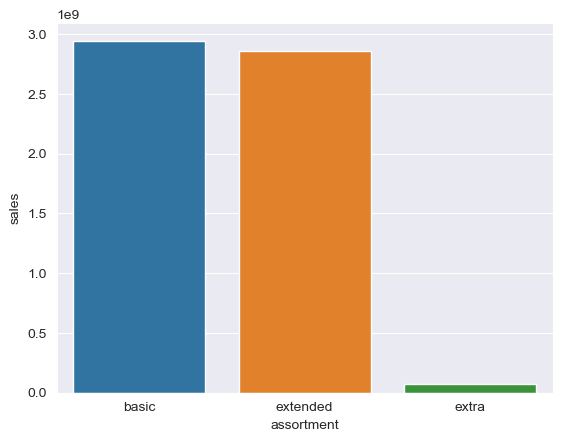

In [50]:
# Agrupa as vendas por grupo de assortment, soma e reseta o índice para transformar em um df e facilitar a visualização
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()

# Exibe um gráfico de barras de aux1
sns.barplot( x='assortment', y='sales', data=aux1);

Análise da Hipótese

- Podemos concluir que as lojas que têm o sortimento extra têm volume de vendas muito abaixo das que têm o assortment do tipo basic e extended. 
- O assortment basic e extended têm maior volume de vendas. 
- Assumimos a ideia de que o maior sortimento é o Extra e o menor é o Basic, pois não há informações na base de dados. 
- À princípio, a hipótese de que lojas com maior sortimento vendem mais não se confirma. Seria o contrário: lojas com maior sortimento (extra), vendem menos. São as lojas com menor sortimento (basic) aquelas que vendem mais. 
- Mas, antes de uma decisão sobre a hipótese, será que durante o tempo sempre as lojas com sortimento Extra venderam um menor volume? Houve algum momento que as lojas com sortimento Extra venderam mais?
- Para isso, preciso da soma das vendas por assortment e por semana, para verificar se houve variação no tempo. 

In [51]:
# Vendas por grupo de assortment e por semana
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()

In [52]:
# Exibe o resultado da pesquisa. Observar que há uma linha para cada grupo de assortment, mesmo estando na mesma semana do ano.
# O ideal é que cada linha fosse uma única semana, e nessa linha, houvessem colunas com os tipos de assortment.
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


In [53]:
# Cria uma tabela pivot onde cada linha é uma semana do ano, as colunas são grupos de assortments e os valores são as vendas
aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales')
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


<Axes: xlabel='year_week'>

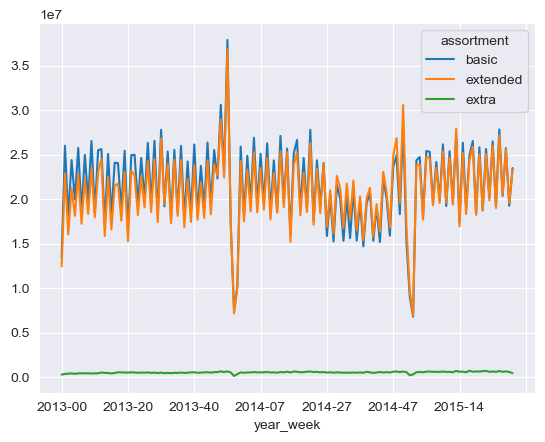

In [54]:
# Plota gráfico da tabela pivot
aux3.plot()

- As vendas nas lojas com assortment Basic e Extended são muito superiores às lojas com assortment Extra. 
- Mas, o comportamento das vendas em Extra é linear? É importante verificar o comportamento de extra de forma isolada, já que o nível elevado de valores dos outros dois grupos esconde o comportamento do grupo Extra.  

<Axes: xlabel='year_week'>

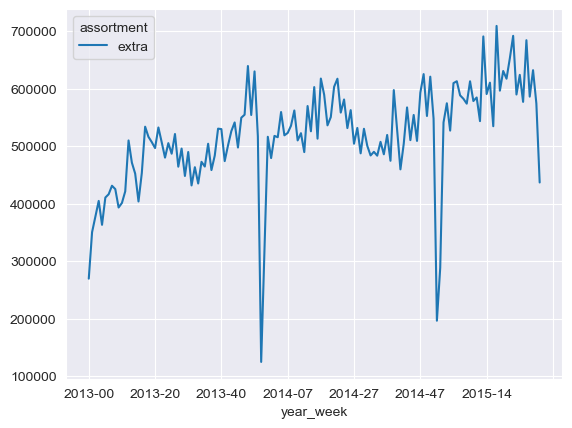

In [55]:
# Gráfico apenas do assortment Extra
aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot( index='year_week', columns='assortment', values='sales').plot()

- Não há linearidade nas vendas das lojas com sortimento Extra. Há semanas específicas de queda acentuada. 
- Porém, o mais importante é verificar que há um crescimento das vendas durante o tempo. 

### Conclusão da hipótese 1: lojas com maior sortimento vendem mais. Hipótese FALSA!
- NÃO. LOJAS COM MAIOR SORTIMENTO VENDEM MENOS. Nesse sentido, essa hipótese é falsa!
- A variável assortment pode ser relevante para o modelo? Sim. Mesmo que o comportamento dos valores de vendas em Basic e Extended sejam similares, há um comportamento diferenciado em Extra. 

### Hipótese 2: Lojas com Competidores mais próximos deveriam vender menos. 

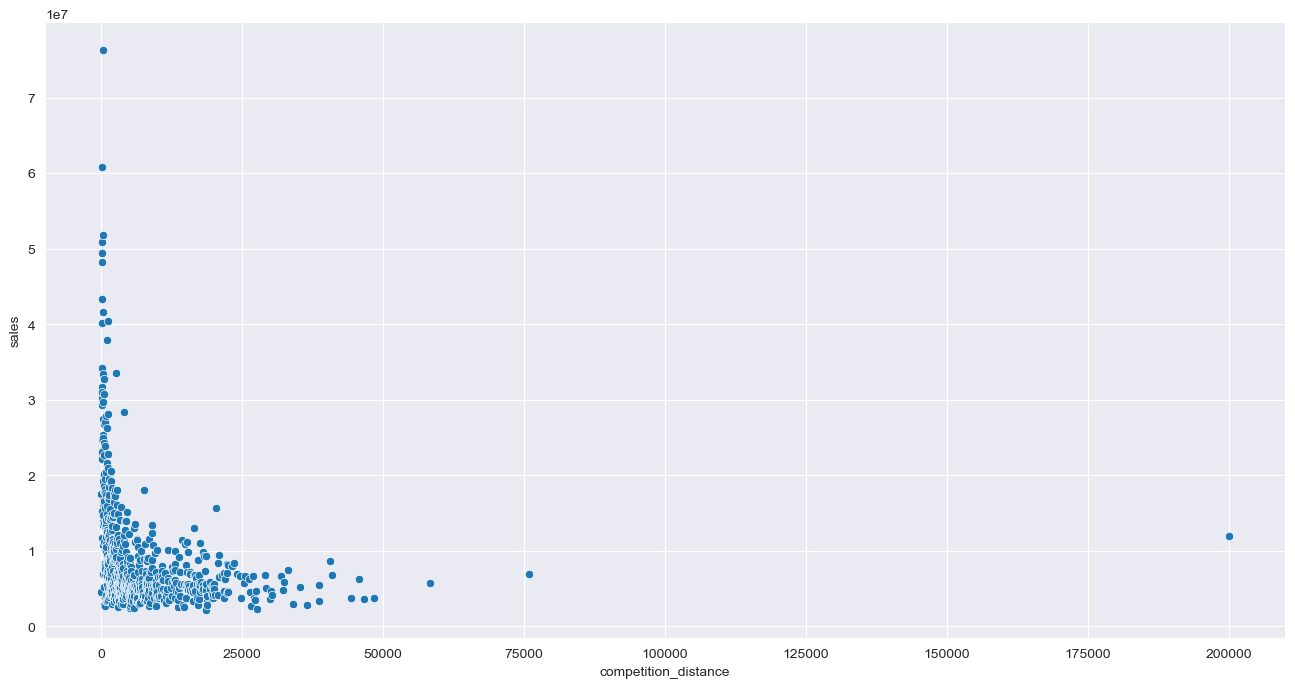

In [56]:
# Filtra no df distancia do competidor e vendas e agrupa por distância do competidor, exibindo uma soma
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# Plota gráfico de dispersão das variáveis distancia do competidor x vendas
plt.figure(figsize=(16, 8))
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

In [57]:
# Como são muitos registros, precisamos criar grupos de distâncias para competition_distance
# Cria grupos de 1000 em 1000 para distância em competition_distance
bins = list( np.arange( 0, 20000, 1000 ) )

# Verifica em qual grupo de intervalos criados cada valor original de competition_distance pertence
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux1.sample(5)

,competition_distance,sales,competition_distance_binned
513,12540.0,5840824,"(12000, 13000]"
455,8740.0,5430658,"(8000, 9000]"
518,12920.0,6133846,"(12000, 13000]"
476,9710.0,4166458,"(9000, 10000]"
573,17540.0,4505981,"(17000, 18000]"


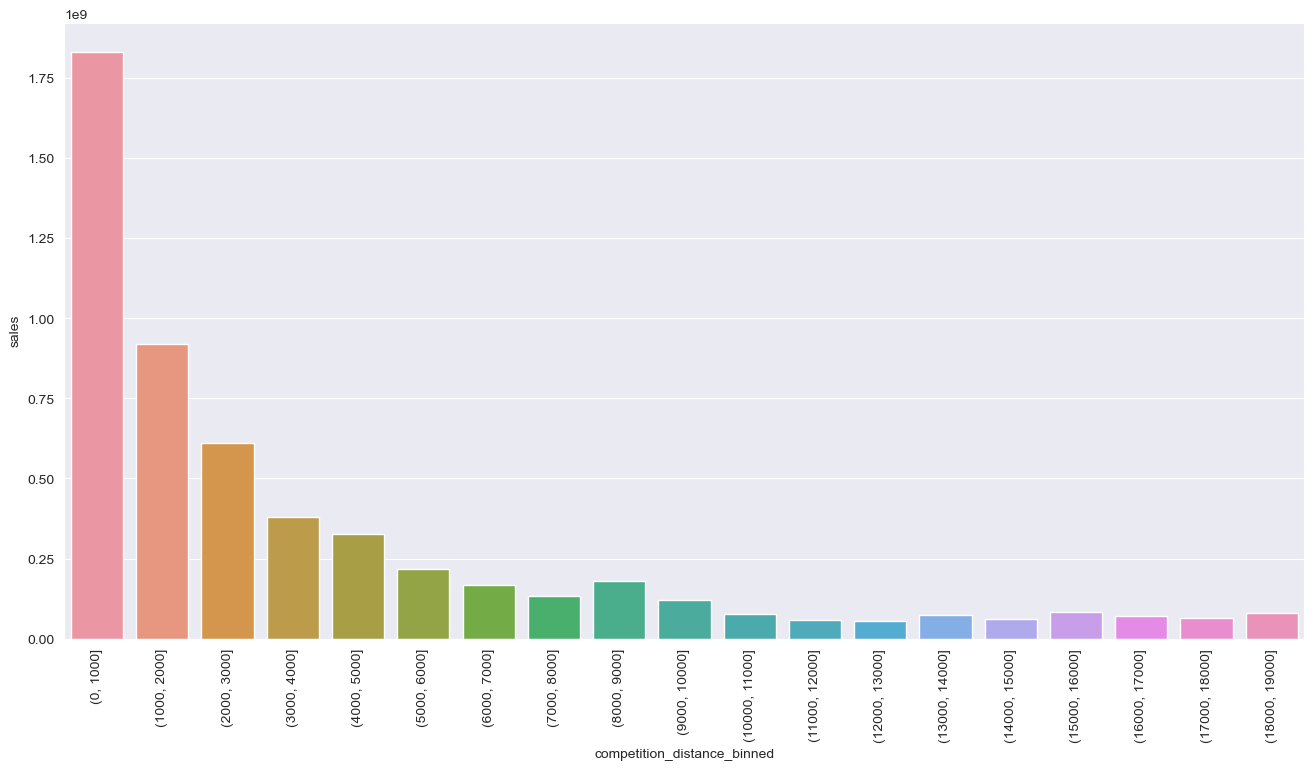

In [58]:
# Faz a soma das vendas de cada grupo de distancias
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

# Plota gráfico com as vendas agrupadas por intervalos de distancia
plt.figure( figsize=(16, 8) )
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
# Gira as labels em 90 graus
plt.xticks( rotation=90 );

- Para verificar se essa variável é importante no modelo, vamos podemos plotar um gráfico da correlação entre a variável competition_distance e sales.
- Vamos utilizar a correlação de pearson

C:\Users\giova\AppData\Local\Temp\ipykernel_85784\335434354.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap( aux1.corr( method='pearson' ), annot=True );


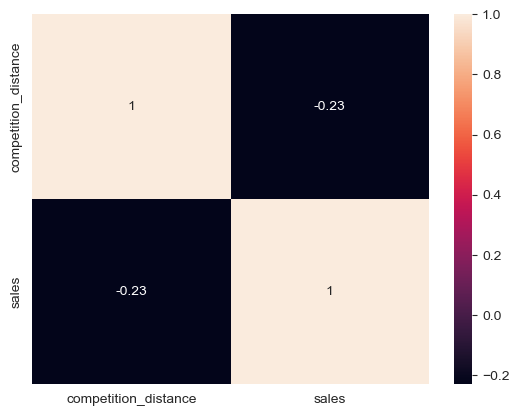

In [59]:
# Plota gráfico da correlação entre distancia do competidor e vendas
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

- Os valores da correlação de pearson sugerem que há pequena correlação negativa entre a distância do competidor e o volume de vendas. 
- Em outras palavras, quanto menor a distãncia do competidor, maior o volume de vendas. Mas, a correlação não é tão forte. 

### Conclusão da Hipótese 2: Lojas com competidores mais próximos vendem menos. Hipótese FALSA!

- Diferente da hipótese inicialmente levantada de que lojas com competidores mais próximos teriam menor volume de vendas, os dados mostram o contrário. 
- Os dados mostram que as lojas com competidores mais próximos vendem mais que lojas com competidores mais distantes. 
- Esse fenômeno, embora surpreendente, pode ter razões com a concorrência, que força as lojas darem mais promoções, por exemplo. É um novo insight a ser investigado. 

### Hipótese 3: Lojas com competidores a mais tempo deveriam vender mais. 

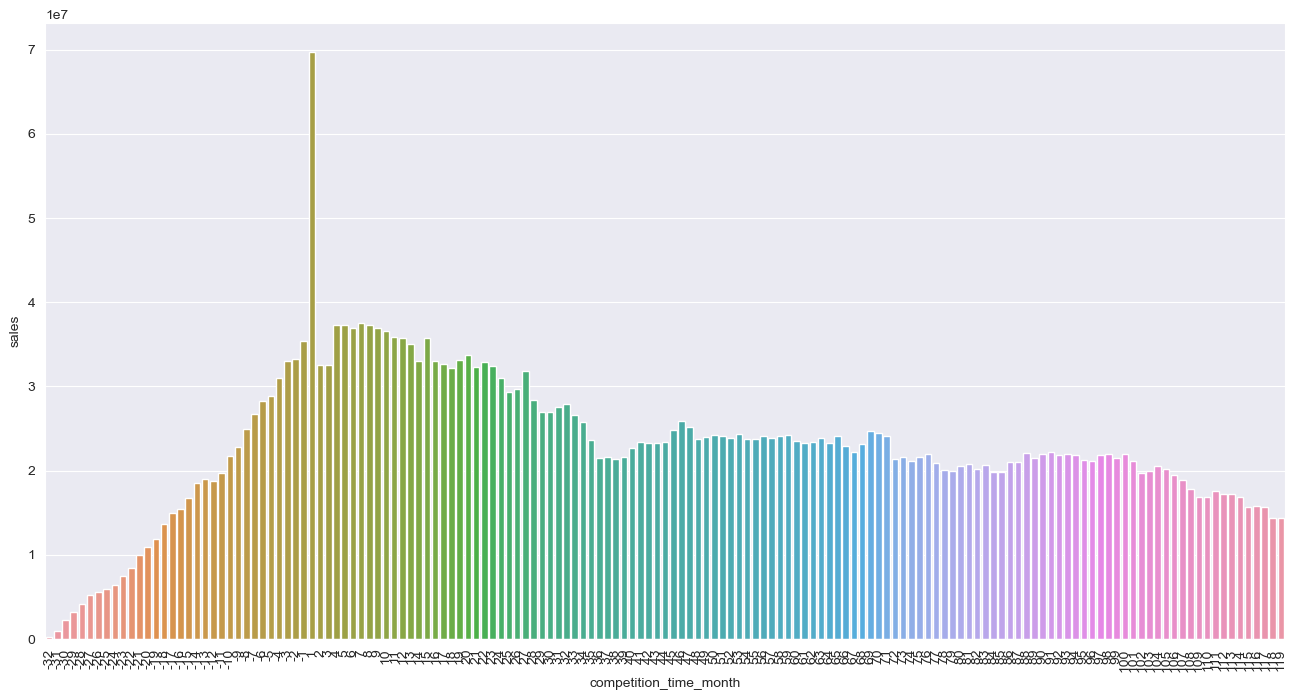

In [60]:
#### Estamos interessados no tempo desde que a competição começou e nas vendas. 

# Agrupa as vendas por número de meses desde que o competidor foi aberto
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()

# Como o resultado em aux1 é muito granular (há tempos variados de abertura), faremos filtros
# Os filtros serão limitar a tempo menor que 120 meses e retirar o tempo menor que 1 mês de competição
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )] 

### Gráficos

# Plota gráfico das vendas por mês de inicio da competição
plt.figure( figsize=(16, 8) )
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
# Gira labels em 90 graus
plt.xticks( rotation=90 );

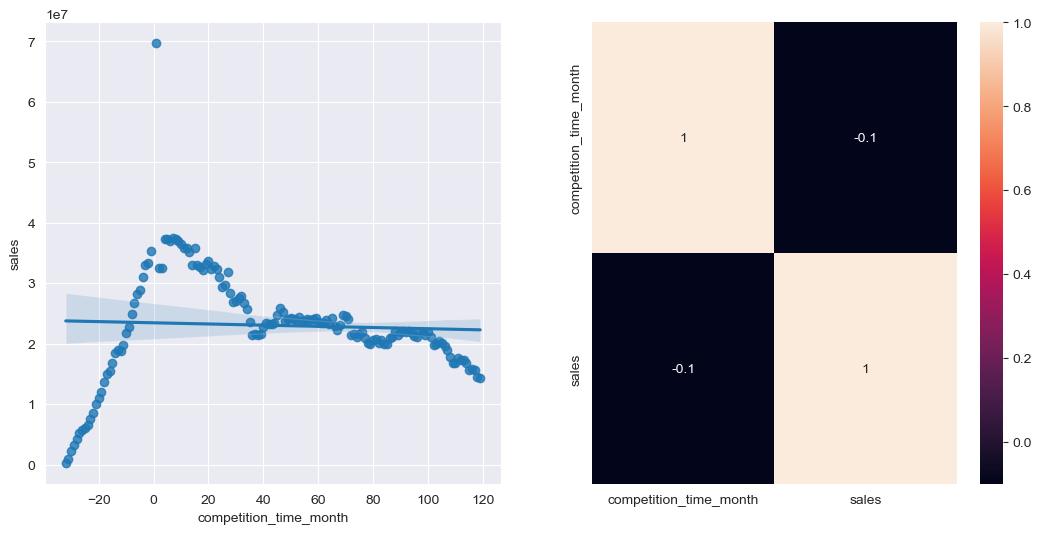

In [61]:
plt.figure( figsize=(20, 6) )

# Plota um regplot dos dados com a linha de tendência
plt.subplot( 1, 3, 1 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

# Plota heatmap com a correlação
plt.subplot( 1, 3, 2 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

Análise do gráfico

- Se a data da venda foi após a abertura do competidor, temos valores positivos. Se a data da venda é antes da abertura do competidor, temos valores negativos. 
- A análise geral é a de quanto maior o tempo de competição, menor as vendas. 
- Lojas com competidores abertos a menos tempo têm mais vendas. Ou seja, QUANTO MAIS RECENTE A COMPETIÇÃO, MAIORES AS VENDAS. 

### Conclusão da Hipótese 3: Lojas com competidores a mais tempo deveriam vender mais: FALSA!!!
- Os dados mostram o contrário: Lojas com competidores abertos a maios tempo vendem menos. 
- QUANTO MENOR O TEMPO DE COMPETIÇÃO, MAIOR O VOLUME DE VENDAS. 
- Embora seja um comportamento surpreendente que contradiz o senso comum, é o que os dados comprovam. Podem haver outras variáveis que explicam tal comportamento.   

### Hipótese 4. Lojas com promoções ativas por mais tempo deveriam vender mais.  

Lembrando sobre os dados de tempo de promoção: 
- Promo é a promoção tradicional. Promo 2 são as promoções extendidas.
- Para calcular o tempo de promoção ativos, fizemos a data observada das vendas menos a data que a promo 2 começou. 
- O resultado pode ser positivo ou negativo. 
- Se for negativo, significa que a venda foi feita no período de promoção tradicional, já que a data da medição será menor que a data da promo2 (que será uma data futura, ou seja, maior que a data da medição). 
- Se for positivo, significa que a data da venda estava dentro da promoção extendida (promo2), já que o início da promoção extendida foi no passado.

In [62]:
# Precisamos de uma variável que diga o tempo desde que a promoção foi ativada e as vendas
df4.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


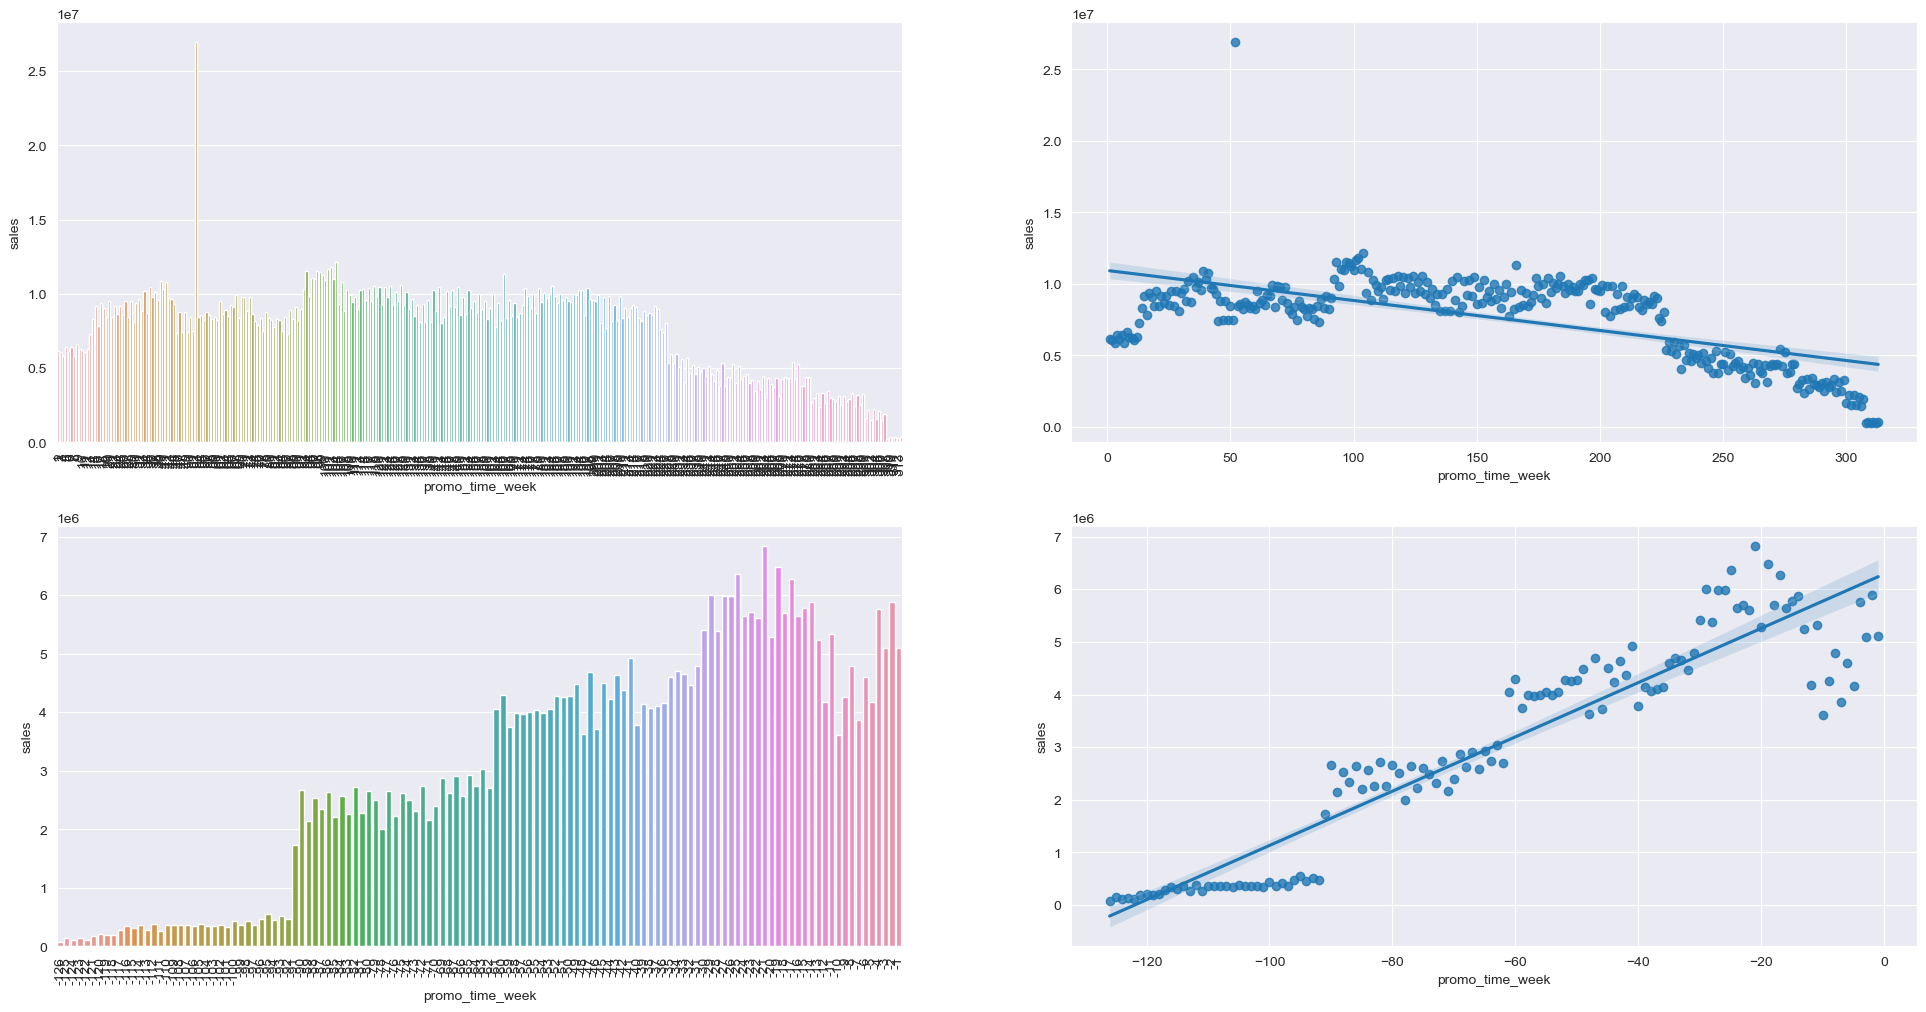

In [63]:
# Agrupa os dados de promo_time_week e vendas
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

### Gráficos para a promoção extendida e promoção regular

plt.figure( figsize=(24, 12) )

# Promo extendida
plt.subplot( 2, 2, 1 )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# Gráfico de tendência
plt.subplot( 2, 2, 2 )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

# Promo regular
plt.subplot( 2, 2, 3 )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks( rotation=90 );

# Gráfico de tendência
plt.subplot( 2, 2, 4 )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );


Análise do gráfico: 
- Gráfico 1: A promoção extendida tem o efeito em vendas limitada no tempo. Observar que a partir de um certo tempo, o número de vendas começa a cair. 
- Gráfico 2: O maior volume de vendas se concentra nas datas próximas ao início da promoção extendida (próximo de 0). Isso pode ser explicado pelas ações de marketing que estariam anunciando o fim do período de promoção regular ou anunciando o início da promoção extendida. 

- A variável é importante para o modelo? Podemos ver pela correlação. 
- O resultado mostra uma fraca correlação negativa entre tempo da promoção e as vendas. Talvez, essa variável não seja interessante para o modelo. 

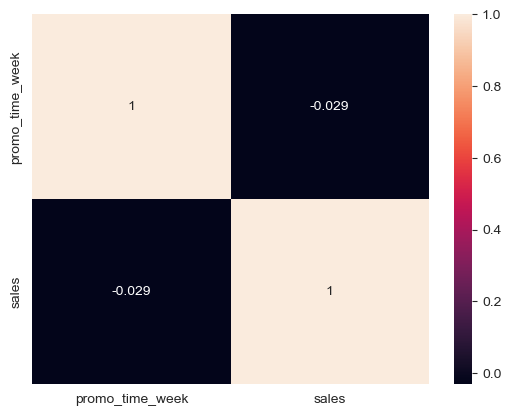

In [64]:
# Mapa de calor da correlação. Lembrar: usamos o dataset inteiro
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### Conclusão da Hipótese 4: Lojas com promoção ativas por mais tempo deveriam vender mais: FALSA !!!
- Os dados mostram que as promoções têm efeito limitado no tempo. 
- Lojas com promoções ativas por mais tempo vendem MENOS. 

### Hipótese 5. Lojas com mais dias de promoção deveriam vender mais.

- Embora essa hipótese seja muito semelhante à anterior, já que lojas com promoções ativas por mais tempo é o mesmo que lojas com mais dias, podemos criar uma nova variável "dias de promoção". 
- Podemos deixar a validação dessa hipótese para o próximo ciclo do CRISP

### Hipótese 6. Lojas com mais promoções consecultivas deveriam vender mais. 

In [65]:
# Agrupar vendas por promo e promo2
aux1 = df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()
# Exibe o dataframe ordenado por vendas
aux1.sort_values('sales', ascending=True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


- Observamos que as lojas que extenderam a promoção não são as que venderam mais. 
- Até mesmo lojas que não fizeram promoção têm mais vendas. 
- Será que esse comportamento se mantém no tempo? 

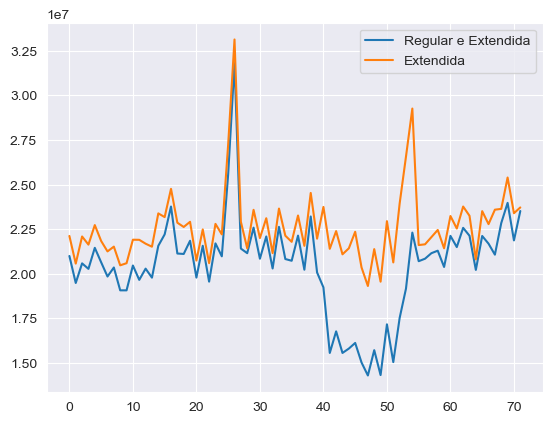

In [66]:
# Filtra as lojas que participaram da promoção regular e extendida, seleciona year week e vendas e agrupa por year_week 
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# Filtra as lojas que participaram da regular e não participaram da extendida
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular e Extendida', 'Extendida'] );

- Observamos pela análise do gráfico que não há muita diferença entre as lojas que participam de ambas as promoções e as que participal apenas da promoção regular. 
- A única diferença é por entre as semanas 40 e 55. Mas o comportamento no restante do ano é muito similar. 
- Portanto, entende-se que essa variável não é muito relevante para o modelo, já que não há variação significativa. 

### Conclusão da Hipótese 6 - Lojas com mais promoções consecutivas deveriam vender mais: FALSA!!!
- As lojas com aplicação da promoção extendida têm maior volume de vendas que as demais. 
- Até mesmo as lojas que não aplicaram a promoção regular possuem maior volume de vendas que aquelas que aplicaram a promoção regular e extendida. 

### Hipótese 7. Lojas abertas durante o feriado de Natal deveriam vender mais. 


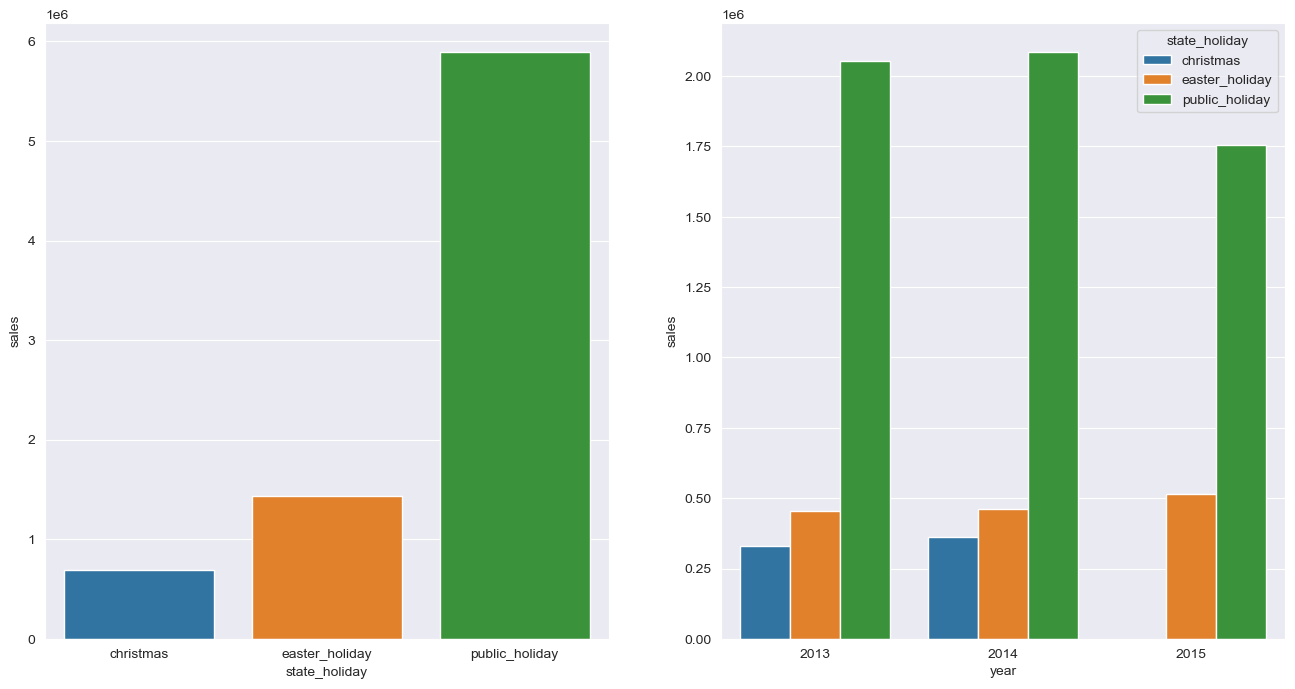

In [67]:
# Filtra do df apenas as vendas em feriados, retirando os dias regulares
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure( figsize=(16, 8) )

plt.subplot( 1, 2, 1 )
# Agrupa as vendas por feriado estadual (natal, pascoa e feriado publico)
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
# Plota gráfico
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
# Plota gráfico
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


Análise dos dados: 
- O feriado de natal é o de menor vendas dentre os feriados. 
- Ao analisar por ano, verificamos que essa realidade é verificada em todos os anos que possuem dados (os dados vão até agosto de 2015). 

### Conclusão da Hipótese 7. Lojas abertas durante o feriado de Natal deveriam vender mais: FALSA!!!
- Os dados mostram que o volume de vendas nas lojas abertas no feriado de natal foram menores que nos demais feriados. 

### Hipótese 8. Lojas deveriam vender mais ao longo dos anos. 

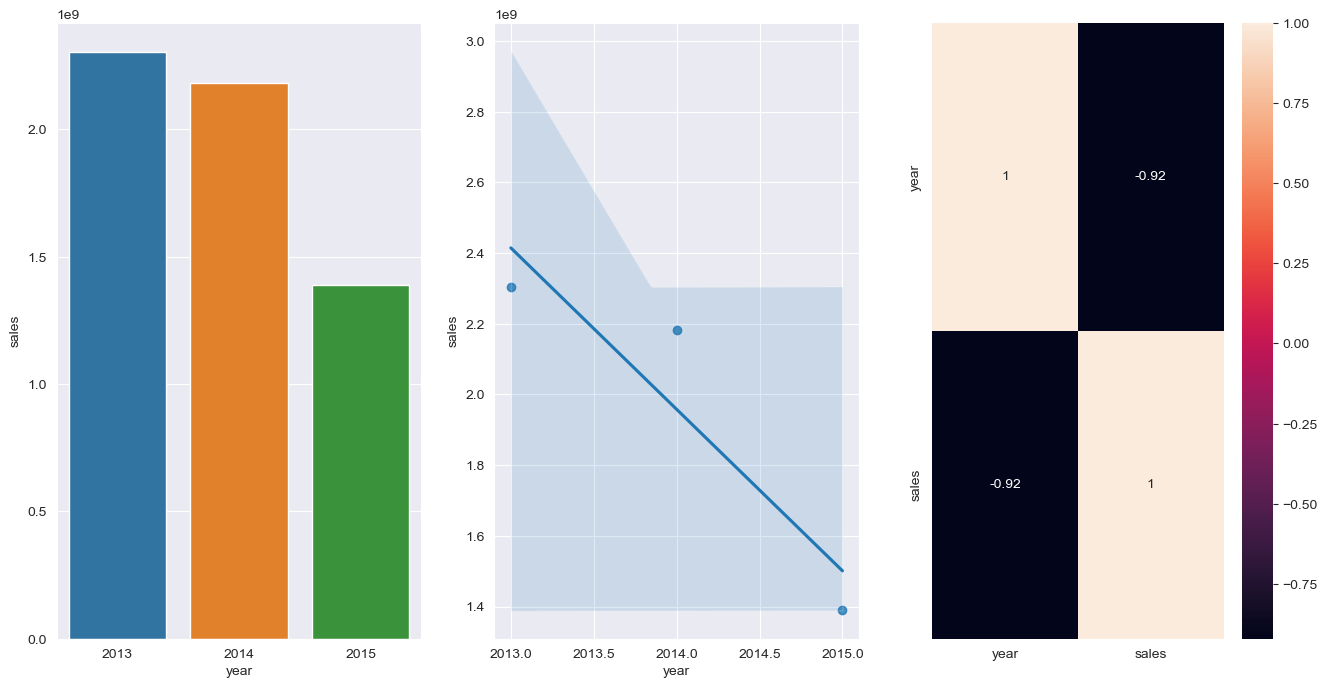

In [68]:
# Agrupa as vendas por anos
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

# Plota gráficos
plt.figure( figsize=(16, 8) )

plt.subplot(1, 3, 1)
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### Conclusão da Hipótese 8: Lojas vendem mais ao longo dos anos: FALSA!!!
- Embora o ano de 2015 não esteja concluído nos dados, observamos que há uma queda no volume de vendas desde 2013.  

### Hipótese 9. Lojas deveriam vender mais no segundo semestre do ano.

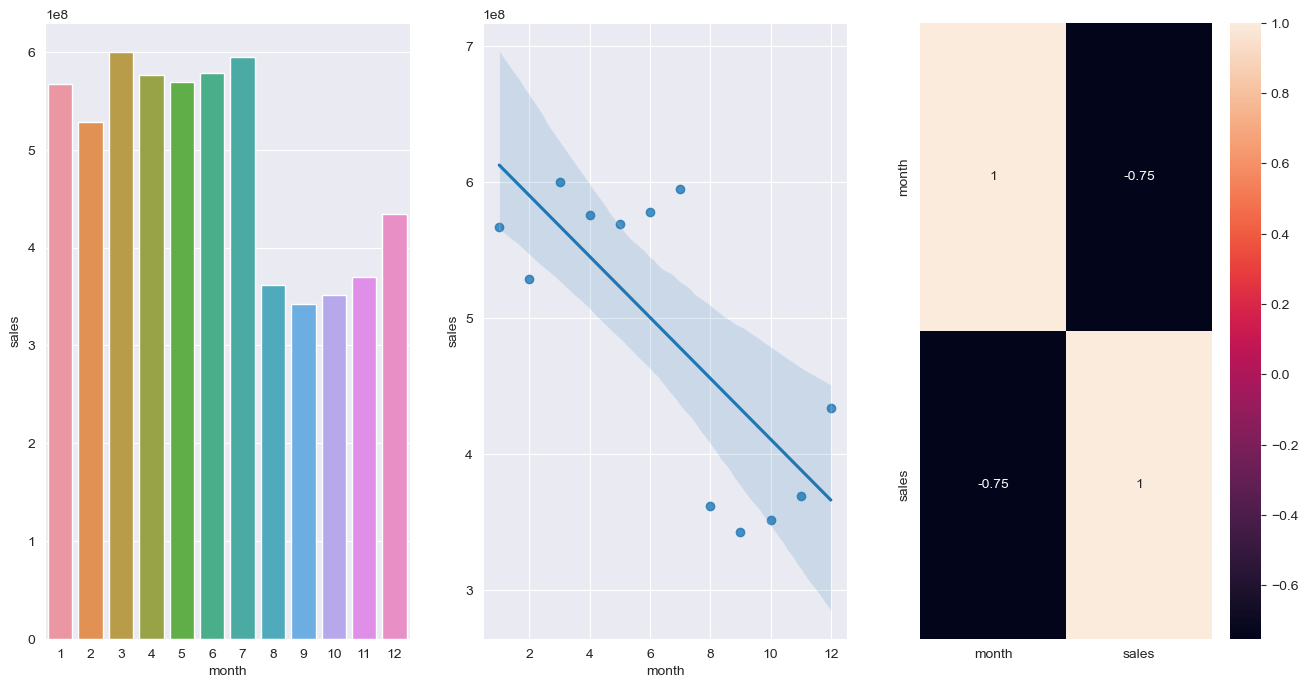

In [69]:
# Agrupa as vendas por meses do ano
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

# Plota gráficos
plt.figure( figsize=(16, 8) )

plt.subplot(1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### Hipótese 9. Lojas deveriam vender mais no segundo semestre do ano: FALSA!!!
- As lojas vendem menos no segundo semestre. 
- A forte correlação negativa mostra que essa variável pode ser importante no modelo. 

### Hipótese 10. Lojas deveriam vender mais após o dia 10 de cada mês. 

C:\Users\giova\AppData\Local\Temp\ipykernel_85784\1838881883.py:19: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap( aux1.corr( method='pearson' ), annot=True );


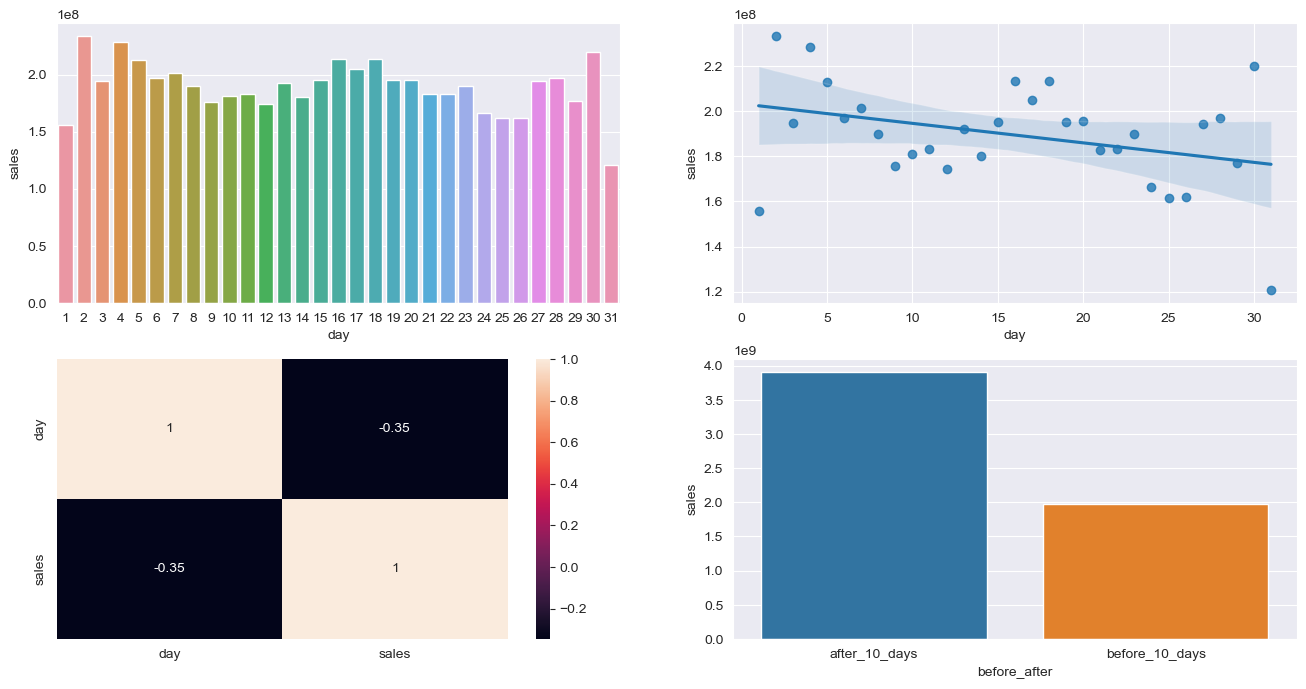

In [70]:
# Agrupa as vendas por dia do mês
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

# Cria variável para agrupar dias antes do dia 10 e após
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
# Agrupa as vendas antes do dia 10 e depois
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

# Plota gráficos
plt.figure( figsize=(16, 8) )

plt.subplot(2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot(2, 2, 2)
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

plt.subplot(2, 2, 4)
sns.barplot( x='before_after', y='sales', data=aux2 );

### Conclusão Hipótese 10. Lojas deveriam vender mais após o dia 10 de cada mês: VERDADEIRA!
- As lojas vendem mais após o dia 10 de cada mês, mesmo que os salários sejam recebidos antes do dia 10. 

### Hipótese 11. Lojas deveriam vender menos aos finais de semana.  

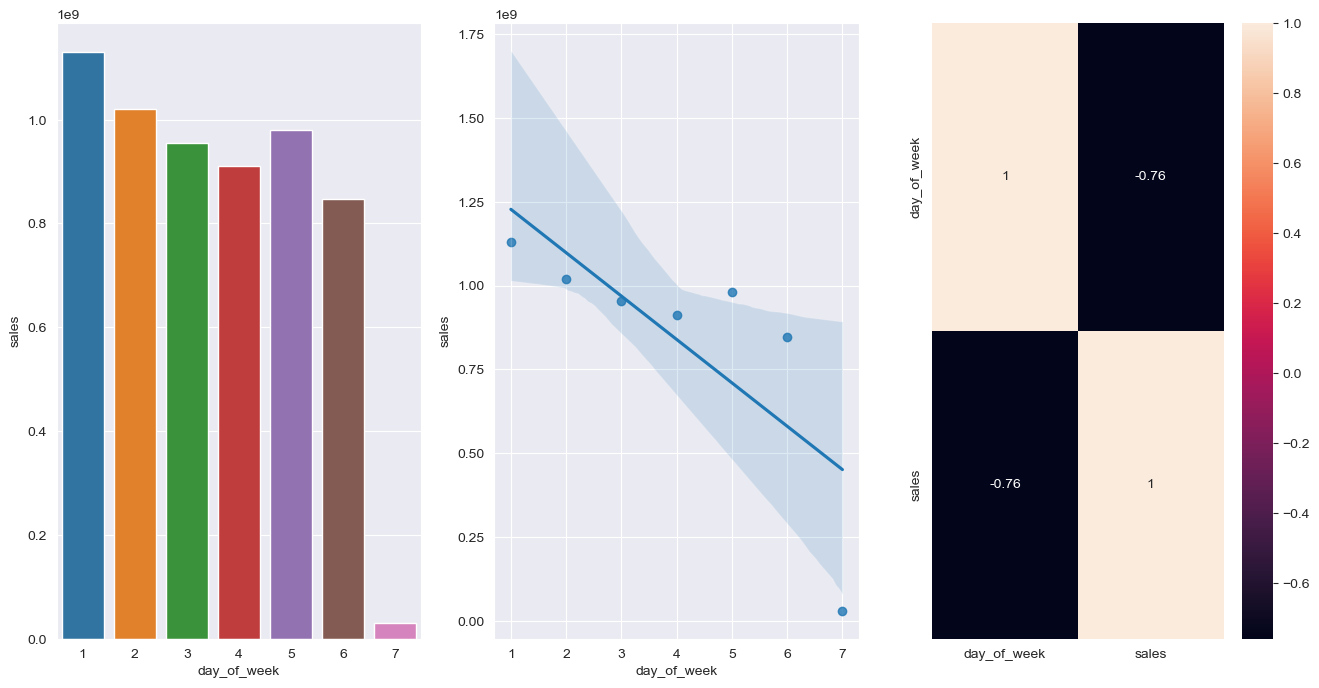

In [71]:
# Agrupa as vendas por dias da semana
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

# Plota gráficos
plt.figure( figsize=(16, 8) )

plt.subplot(1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### Conclusão Hipótese 11. Lojas deveriam vender menos aos finais de semana: VERDADEIRA!!!
- Verificando o gráfico de vendas por dias da semana, o dia 1 (segunda) é o que possui maior volume de vendas. 
- Dias 6 (sábado) vende menos que os dias de semana e 7 (domingo) é o de menor vendas.
- Há uma correlação negativa relativamente forte entre dias da semana e vendas.    

### Hipótese 12. Lojas deveriam vender menos durante os feriados escolares. 

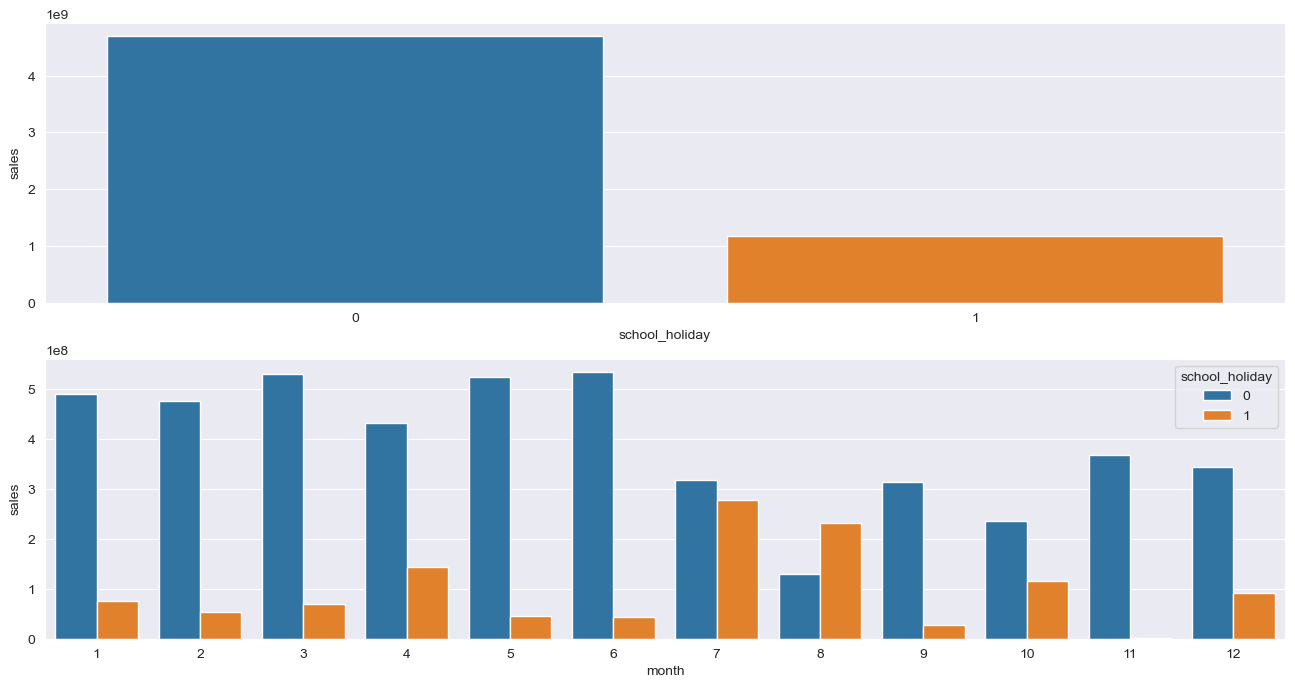

In [72]:
# Agrupa as vendas por feriado escolar
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

# Plota barplot dos dados
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
sns.barplot( x='school_holiday', y='sales', data=aux1 );

# Para verificar se é um comportamento durante todo o ano, inclui o mês do ano no agrupamento
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

# Plota barplot dos dados
plt.subplot(2, 1, 2)
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );



Análise do gráfico
- No geral, há mais vendas fora de feriados escolares, já que há mais dias sem feriado do que com feriado. 
- Em julho, há vendas quase equiparadas. Isso pode ser explicado por ser um mês de férias.
- Em agosto, há mais vendas em dias com feriados escolares. Pode ser explicado pelo maior número de dias de férias (no verão no Hemisfério Norte).

### Conclusão Hipótese 12. Lojas deveriam vender menos durante os feriados escolares: VERDADEIRA!
- De fato, as lojas vendem menos durante os feriados escolares em todos os meses, com excessão dos meses de férias escolares. 

### Resumo da Análise de Hipóteses

In [73]:
# Cria tabulação com resumo das hipóteses e sua relevância para o modelo
tab = [['Hipóteses', 'Conclusão', 'Relevância'], 
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
       ]
print ( tabulate( tab, headers='firstrow') )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical attributes

In [74]:
# Exibe parte do dataset que possui apenas as variáveis numéricas
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


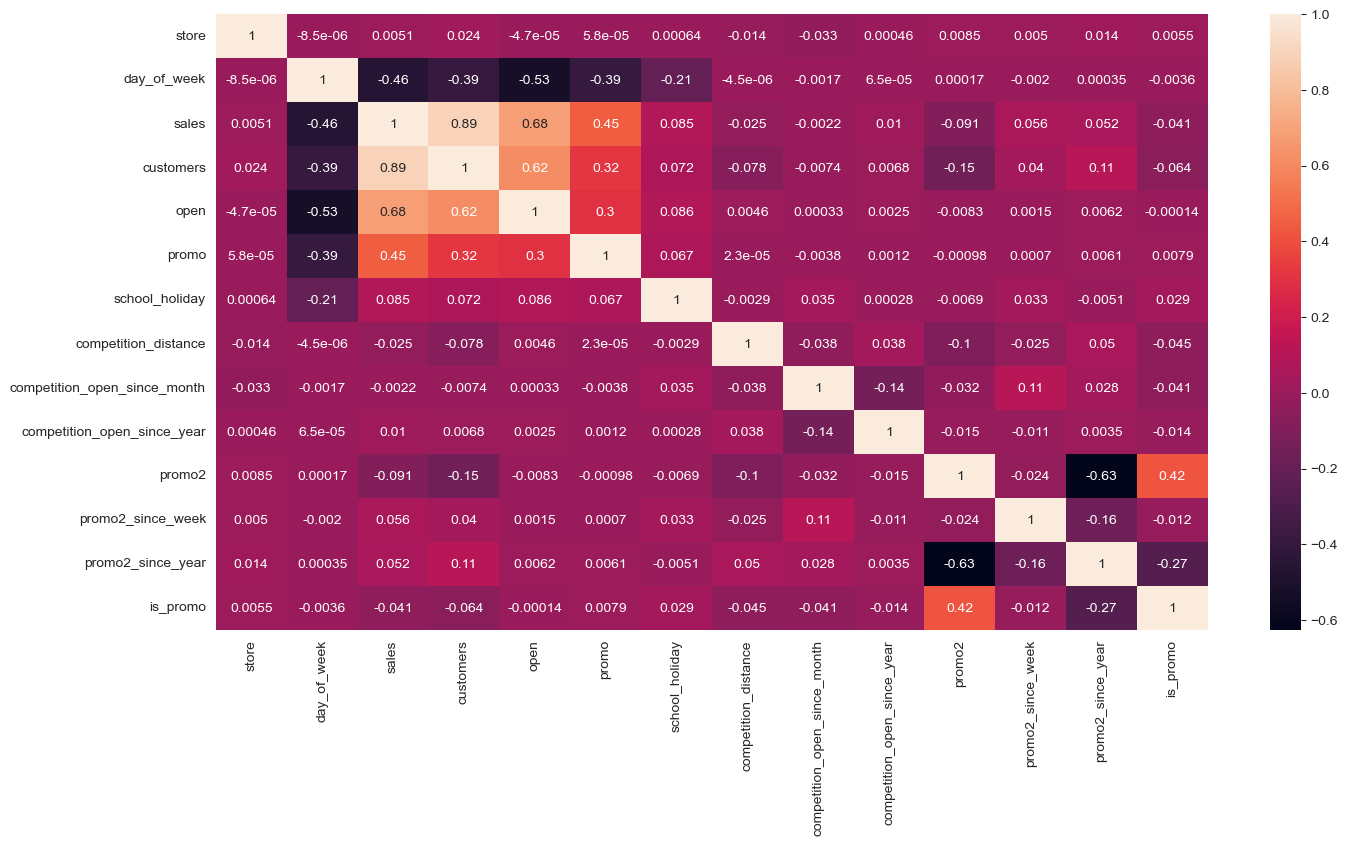

In [75]:
# Faz correlação entre todas as variáveis numéricas
correlation = num_attributes.corr( method='pearson' )

# Plota mapa de calor com as correlações
plt.figure( figsize=(16, 8) )
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

In [76]:
# Cria um dataset das variáveis categóricas atualizadas
a = df4.select_dtypes( include='object' )

In [77]:
# Exibe o dataset só com variáveis categóricas
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


- Para verificar a correlação entre variáveis categóricas, teremos que usar o teste V de Cramer (Cramer V)
- Esse teste estatístico é uma variação do teste Qui Quadrado. No Python, devemos implementá-lo na mão, com base na fórmula do teste disponível na bibliografia. 
- O código da função está na seção Help Functions, para melhor organizaçao do projeto. 

In [78]:
# Aplica a função do teste V de Krammer nas combinações possíveis
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Cria dataframe com uma tabela das possibilidades de combinação acima
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6], 
               'assortment': [a7, a8, a9]} )


# Para melhor visualização, atribui como index do df as colunas da tabela
d = d.set_index( d.columns )

# Exibe o dataset final
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


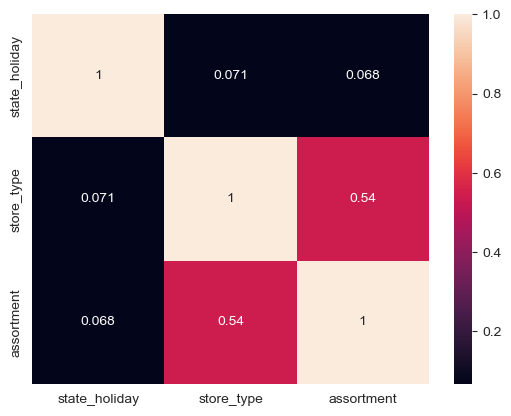

In [79]:
# Cria mapa de calor com a correlaçao das variáveis categóricas do df
sns.heatmap(d, annot=True);

- O V de Krammer, diferente da correlação de pearson, só tem valores positivos. Ou só temos correlação positiva, ou não temos correlação
- Ele vai de zero a 1. Quanto mais próximo de 1, maior a correlação entre as duas variáveis categóricas. 
- As maiores correlações estão entre store_type e assortment. Isso faz sentido, pois quanto maior a loja, maior o mix de produtos vendidos. 

# 5.0 - Preparação dos Dados

In [80]:
# Faz uma cópia dos dados até então
df5 = df4.copy()

## 5.1 - Normalização

- Com base na análise dos gráficos de distribuição das variáveis do dataset do projeto, observamos que nenhuma possui uma distribuição que se aproxima de uma distribuição normal. 
- Logo, a melhor decisão é não utilizar a normalização na preparação dos dados. 

## 5.2 - Rescaling

In [81]:
# Identifica as variáveis que aplicaremos o Rescaling
a = df5.select_dtypes( include=['int64', 'float64'] )
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day
0,1,5,5263,1,1,1270.0,0,0,2015,7,31
1,2,5,6064,1,1,570.0,1,1,2015,7,31
2,3,5,8314,1,1,14130.0,1,1,2015,7,31
3,4,5,13995,1,1,620.0,0,0,2015,7,31
4,5,5,4822,1,1,29910.0,0,0,2015,7,31


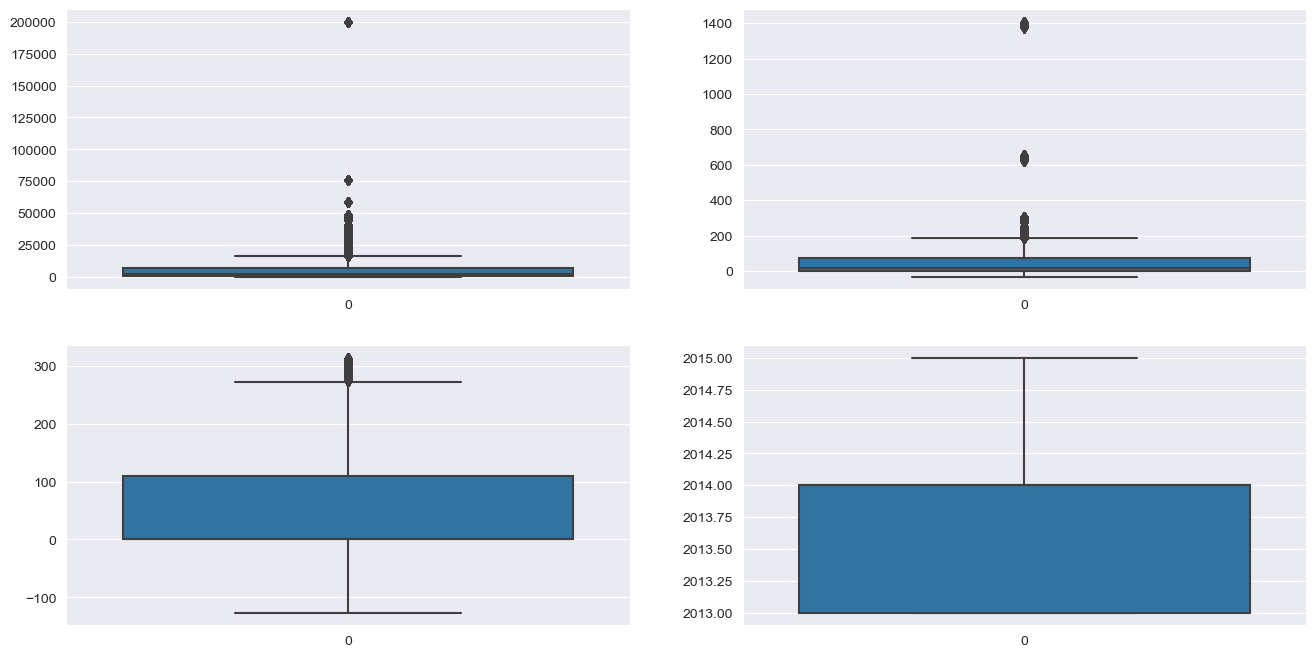

In [82]:
# Verificando se as variáveis possuem outliers muito relevantes
plt.figure( figsize=(16, 8) )

plt.subplot(2, 2, 1)
sns.boxplot( df5['competition_distance'] );

plt.subplot(2, 2, 2)
sns.boxplot( df5['competition_time_month'] );

plt.subplot(2, 2, 3)
sns.boxplot( df5['promo_time_week'] );

plt.subplot(2, 2, 4)
sns.boxplot( df5['year'] );

In [83]:
# Dada a presença marcante de outliers, iremos usar o robust scale para usar apenas o q1 e q3
rs = RobustScaler()

# Instancia o MinMax scaler para as variáveis onde outliers não são tão relevantes
mms = MinMaxScaler()

In [84]:
# Aplica o MinMaxScaler e o RobustScaler nas variáveis numéricas não cíclicas

### competition_distance: outliers relevantes - RobustScale

# Usa o fit transform, que encontra o quartil 1 e 3 dos dados. Teremos a variável em uma nova escala, retirando os outliers
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

### competition_time_month: outliers relevantes - RobustScale

# Usa o fit transform, que encontra o quartil 1 e 3 dos dados. Teremos a variável em uma nova escala, retirando os outliers
df5['competiton_time_month'] = rs.fit_transform( df5[['competition_distance']].values )

### promo_time_week: pouca relevância dos outliers - MinMaxScale

# Dado que os outliers não são tão relevantes, usa o MinMax Scaler para fazer o Rescaling
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )


### year: pouca relevância dos outliers - MinMaxScale

# Dado que os outliers não são tão relevantes, usa o MinMax Scaler para fazer o Rescaling
df5['year'] = mms.fit_transform( df5[['year']].values )

C:\Users\giova\AppData\Local\Temp\ipykernel_85784\2875780222.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['competition_distance'] );
C:\Users\giova\AppData\Local\Temp\ipykernel_85784\2875780222.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['competition_time_month'] );
C:\U

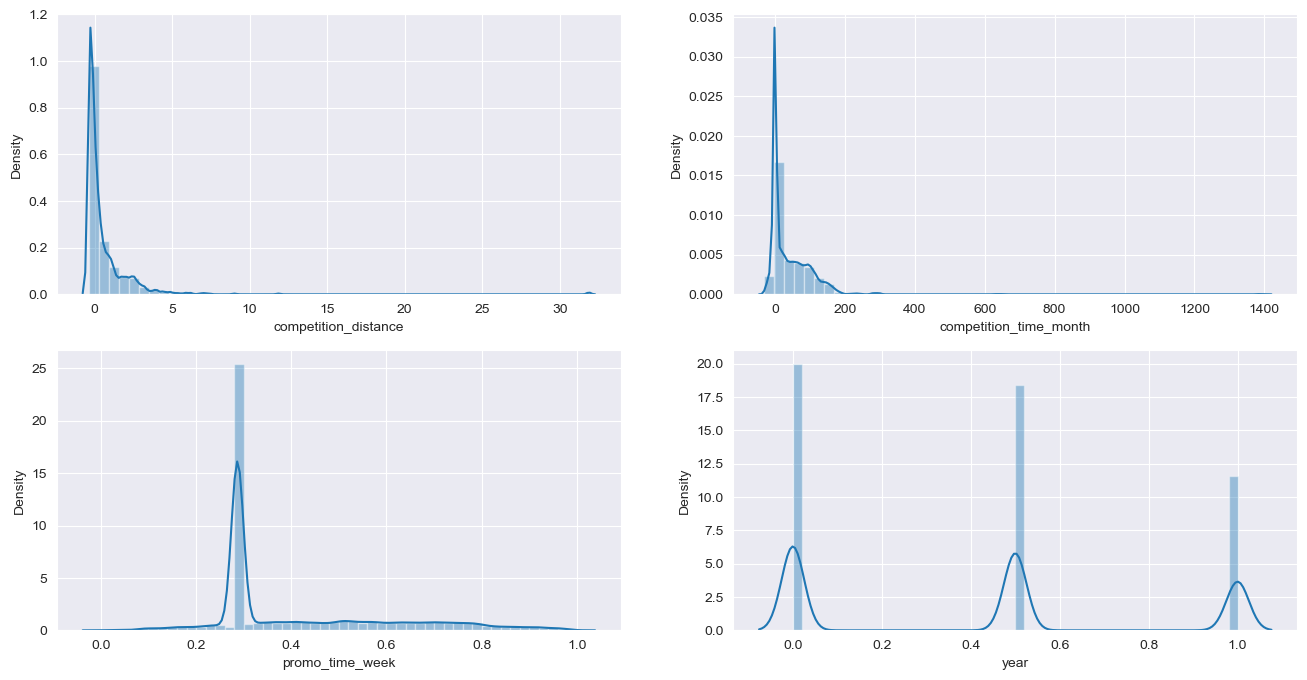

In [85]:
# Plota gráfico com a nova distribuição
plt.figure( figsize=(16, 8) )

plt.subplot(2, 2, 1)
sns.distplot( df5['competition_distance'] );

plt.subplot(2, 2, 2)
sns.distplot( df5['competition_time_month'] );

plt.subplot(2, 2, 3)
sns.distplot( df5['promo_time_week'] );

plt.subplot(2, 2, 4)
sns.distplot( df5['year'] );

- Ao comparar com a distribuição na seção 4.1 Análise Univariada, observamos que o formato da distribuição permanece o mesmo. 
- Porém, agora temos a variável em uma nova escala. 

## 5.3 - Transformação

### 5.3.1 - Encoding

In [86]:
# Dataframe sem aplicação do encoding nas variáveis
df5.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,-0.170968,-0.283871,1.903226,-0.275806,4.448387


In [87]:
#### Variáveis categóricas que serão transformadas em numéricas por encoding: state_holiday; store_type; assortment 

### state_holiday (ou é feriado, ou não é) 
# Utiliza o One Hot Encoding para substituir o valor da variável por 0 ou 1
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

#####################

### store_type (Na descrição do dataset não informa a definição do tipo de lojas, apenas que há lojas a, b, c, etc)
# Vamos utilizar o Label Encoder, do pacote sklearn.preprocessing 

# Instancia o objeto label encoder
le = LabelEncoder()
# Aplica o Label Encoder
df5['store_type'] = le.fit_transform( df5['store_type'] )

#####################

### assortment (tipos de sortimento: basic (será igual a 1); extra (será igual a 2); extended (será igual a 3))
# Uso do Ordinal Encoding

# Cria dicionário para atribuir valores a cada tipo
assortment_dict = {'basic': 1, 'extra': 2,'extended': 3}

# Substitui os valores de assortment no df5, criando uma forma de aplicar o Ordinal Encoding nos dados
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [88]:
# Exibe o df5 com as modificações
df5.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
school_holiday,1,1,1,1,1
store_type,2,0,0,2,0
assortment,1,1,1,3,1
competition_distance,-0.170968,-0.283871,1.903226,-0.275806,4.448387
competition_open_since_month,9,11,12,9,4


5.3.2 - Response Variable Transformation

C:\Users\giova\AppData\Local\Temp\ipykernel_85784\2607992501.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( a );


C:\Users\giova\AppData\Local\Temp\ipykernel_85784\2607992501.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['sales'] );


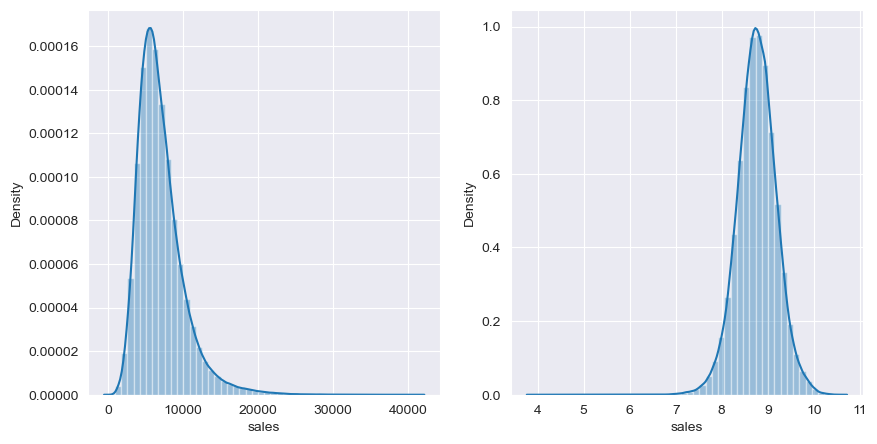

In [89]:
a = df4['sales']

### Aplicação da transformação logarítmica sobre os dados de vendas
df5['sales'] = np.log1p( df5['sales'] )

# Plota gráficos 
plt.figure( figsize=(10, 5) )

# Exibe gráfico da distribuição da variável sales antes da transformação
plt.subplot(1, 2, 1)
sns.distplot( a );

# Exibe gráfico da distribuição da variável sales após a transformação
plt.subplot(1, 2, 2)
sns.distplot( df5['sales'] );

- Os dados da variável sales têm distribuição semelhante a uma distribuição de Poisson. 
- Ao aplicar o log tem todos os dados, temos um distribuição sem caudalidade e mais próxima da distribuição normal.   

5.3.3 - Nature transformation

In [90]:
#### Para as variáveis com natureza cíclica, iremos aplicar a transformação cíclica utilizando seno e cosseno 

### month

# Cria uma nova coluna com valores de seno e cosseno de cada mês da data de venda (ciclo = 12 meses)
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

### day

# Cria uma nova coluna com valores de seno e cosseno de cada dia da data de venda (ciclo = 30 dias)
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

### week of year

# Cria uma nova coluna com valores de seno e cosseno de cada semana do ano da data de venda (ciclo = 52 semanas)
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )


### day of week

# Cria uma nova coluna com valores de seno e cosseno de cada dia da semana da data de venda (ciclo = 7 dias)
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) ) 

In [91]:
# Mostra 10 linhas de exemplo do df transformado 
df5.sample(10).T

,159658,586005,524284,564194,341034,349777,708223,888057,743704,481212
store,214,301,1020,790,1037,320,984,188,785,318
day_of_week,2,3,3,2,4,1,6,5,2,6
date,2015-03-10 00:00:00,2014-01-22 00:00:00,2014-03-19 00:00:00,2014-02-11 00:00:00,2014-09-11 00:00:00,2014-09-01 00:00:00,2013-10-05 00:00:00,2013-04-26 00:00:00,2013-09-03 00:00:00,2014-04-26 00:00:00
sales,8.820552,8.544419,9.179778,8.6174,8.688791,10.050182,8.705,8.53149,8.440528,8.421123
promo,0,1,1,0,0,1,0,1,0,0
school_holiday,0,0,0,0,0,0,0,0,1,0
store_type,3,0,0,3,0,0,2,3,3,3
assortment,1,3,1,3,3,3,1,1,3,3
competition_distance,1.019355,0.351613,-0.369355,1.087097,-0.351613,-0.341935,-0.304839,-0.23871,-0.219355,4.83871
competition_open_since_month,7,3,8,12,9,9,10,4,7,3


# 6.0 - Feature Selection

In [92]:
# Faz uma cópia dos dados até então
df6 = df5.copy()

## 6.1 - Split dataframe into training and test dataset

In [93]:
df6.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,8.568646,8.71029,9.025816,9.546527,8.481151
promo,1,1,1,1,1
school_holiday,1,1,1,1,1
store_type,2,0,0,2,0
assortment,1,1,1,3,1
competition_distance,-0.170968,-0.283871,1.903226,-0.275806,4.448387
competition_open_since_month,9,11,12,9,4


In [94]:
# Converter para int64
df6['store_type'] = np.int64(df6['store_type'])
df6['competition_open_since_month'] = np.int64( df6['competition_open_since_month'] )
df6['competition_open_since_year'] = np.int64( df6['competition_open_since_year'] )
df6['promo2_since_week'] = np.int64( df6['promo2_since_week'] )
df6['promo2_since_year'] = np.int64( df6['promo2_since_year'] )
df6['competition_time_month'] = np.int64( df6['competition_time_month'] )
df6['state_holiday_christmas'] = np.int64( df6['state_holiday_christmas'] )
df6['state_holiday_easter_holiday'] = np.int64( df6['state_holiday_easter_holiday'] )
df6['state_holiday_public_holiday'] = np.int64( df6['state_holiday_public_holiday'] )
df6['state_holiday_regular_day'] = np.int64( df6['state_holiday_regular_day'] )

In [95]:
# Lista as colunas que serão deletadas do dataframe
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

# Faz a retirada no df6 das colunas que não serão utilizadas 
df6.drop( cols_drop, axis=1, inplace=True )

In [96]:
# Tipo dos dados df6
df6.dtypes

store                                    int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                   float64
competition_time_month                   int64
promo_time_week                        float64
competiton_time_month                  float64
state_holiday_christmas                  int64
state_holiday_easter_holiday             int64
state_holiday_public_holiday             int64
state_holiday

- Na separação de dados de treino e teste, (treino para o modelo aprender, teste para testar a acurácia do modelo), é preciso levar em conta que o projeto possui dados temporais. 
- Logo, não posso misturar dados passados e futuros nos dados de treino, sob o risco de causar overfitting no modelo. 
- Como as vendas por loja são em relação ao tempo e quero fazer a previsão para as próximas 6 semanas, vou obter as vendas das últimas 6 semanas e separar como dados de teste. 
- Os dados de vendas do primeiro dia de vendas até a data limite antes das últimas seis semanas, utilizaremos como treino. As vendas nas últimas seis semanas serão os dados de teste. 
- Primeiro vamos agrupar os dados por loja e por data e obter a data mínima de venda de cada uma das lojas. O objetivo é verificar qual a data inicial das vendas para cada loja. 
- Depois, faremos a mesma operação para obter a data máxima de vendas. 
- O próximo passo é subtrair seis semanas da data máxima de vendas (6 * 7 dias = 42 dias)

In [97]:
## Verificando a data mínima
# Agrupa os dados por loja. Verificamos que aparentemente a data mínima para todas as lojas parece a mesma: 2/1/2013
df6[['store', 'date']].groupby( 'store' ).min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [98]:
# Obtem a data máxima e subtrai 6 semanas para estipular a data limite
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

Dados de treino:
- Temos que a data mínima das vendas é o dia 2/1/2013 e a data máxima é 19/6/2015
- Os dados de treino serão todas as vendas entre esse período. 

Dados de teste: 
- Vendas após a data de 19/6/2015

In [99]:
# trainning dataset
X_train = df6[df6['date'] < '2015-06-19']
# Apenas coluna sales
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] > '2015-06-19']
y_test = X_test['sales']

# Imprime as datas mínimas e máximas para verificação
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-20 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 - Boruta as Feature Selector

In [100]:
### Trainning and test dataset for Boruta

# Retira as colunas date e sales do df de treino X e o transforma em vetor
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values

# Atribui à variavel os valores de y train transformado em vetor 
y_train_n = y_train.values.ravel()

In [103]:
### Define Random Forest Regressor
rf = RandomForestRegressor( n_jobs=-1 )

### Configuração do algoritmo Boruta
# 1. Seleção de features pelo modelo Random Forest
# 2. N estimators em auto para o próprio algoritmo encontrar o melhor número de árvores
# 3. Verbose = 2 para que seja possível ver o print do que é feito, dada o elevado tempo de processamento
# 4. Random state partindo do mesmo início, da mesma aleatoriedade. Número 42 escolhido aleatoriamente
# 5. Os dados repassados devem ser um vetor numpy, não um dataframe
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	9


- O Boruta efetuou 9 iterações. 
- 19 variáveis foram consideradas relevantes
- 9 variáveis foram consideradas não relevantes. 

6.2.1 - Best Features from Boruta

In [105]:
# Support do Boruta: fornece alguns números informando qual a classificação de cada variável 
# em relação à relevância para o modelo. 
cols_selected = boruta.support_.tolist()


## Melhores features
# Obtem todas as colunas e linhas do dataset selecionados pelo boruta
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 ) 
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Colunas não selecionadas pelo Boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [106]:
# Exibe as variáveis selecionadas pelo Boruta
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'competiton_time_month',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [107]:
# Variáveis não relevantes
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

- Comparando o resultado do algoritmo Boruta e o resultado das hipoteses e relevância de variáveis que fizemos na análise exploratória, vimos que
as variáveis sugeridas anteriormente foram todas confirmadas. 

## 6.3 - Manual Feature Selection

In [108]:
# Para evitar ter que rodar todo o algoritmo novamente, criar uma lista com os resultados do algoritmo 
# adicionando também as variáveis month_sin; month_cos; week_of_year_sin, que julgo relevantes devido ao resultado da análise exploratória
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# Colunas a serem adicionas: sales (varíavel resposta) e date
feat_to_add = ['date', 'sales']

# Features finais
cols_selected_boruta.extend( feat_to_add )

In [109]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']